# Hyperparameter tuning, clustering, and fitting

We predict the prices of houses sold in Ames, Iowa, using the following method:

1. Initial preprocessing, including relabelling ordinal categorical data to integers, dropping some features that are either correlated to others or do not impact house price, and dealing with missing values.
2. Most of the features are then grouped according to what they describe (e.g. the exterior of the house), and an extreme gradient boost model is used to get a predicted sale price based on these features alone.
3. These features are then reduced to just two by using principal component analysis, and remain in the dataframe along with a small number of core features such as neighborhood rating, total square feet etc.
4. We split the data into clusters, and then train another XGBoost model on each cluster before combining them into the final prediction.

## Coarse to fine hyperparameter tuning

The notebook is set up to perform a grid search and save the results. The next time the notebook is run, it reloads the best model hyperparameters from the previous run and adds extra nearby values to extend the search. (This is a simple coarse to fine algorithm and is not intended to achieve the optimal results).

## Contents:
* [Preprocessing](#Preprocessing)
* [Missing values](#missing)
* [Feature correlation](#corr)
* [Feature engineering](#featureengineering)
* [Visualizing the new features](#new_feature_viz)
* [Visualizing through dimension reduction](#dimred)
* [Clustering](#clustering)
* [Model training](#modelling)
* [Submission](#Submission)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from scipy.stats import f_oneway, norm
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, MinMaxScaler, PolynomialFeatures, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, ShuffleSplit, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from os.path import exists, getsize
from ast import literal_eval
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [2]:
def load_data():
    global df 
    global df_orig
    df = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
    df_orig = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv', index_col='Id')
    global df_test_orig 
    global df_test
    df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')
    df_test_orig = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv', index_col='Id')

# Preprocessing<a id='preprocessing'></a>

The following cell contains all preprocessing performed on the datasets.

* The date columns are converted to a datetime column.
* Each feature which has some sort of categorical rating is converted to integers.
* We calcualte the total finished square footage.
* We calculate the total number of bathrooms in the house (including the basement).
* We drop some superfluous features.
* We create a proximity feature which measures the quality of what is nearby (e.g. nearby highway reduces this score, nearby park increases it).
* We create ratings for fireplaces and for pools.

In [3]:
# Combine month and year sold into a date sold column.

def add_date_sold(data):
    data['DateSold'] = data['YrSold'].astype('str')+'-'+data['MoSold'].astype('str')
    data['DateSold'] = pd.to_datetime(data['DateSold'], format="%Y-%m")
    data.drop('YrSold', axis=1, inplace=True)
    data.drop('MoSold',axis=1,inplace=True)
    
def categorical_and_ratings_columns(data):
    # Columns with (unordered) categorical data.
    
    cat_columns = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope','Neighborhood',
                   'Condition1','Condition2','BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType',
                  'Foundation', 'BsmtFinType1','BsmtFinType2','Heating', 'CentralAir','Electrical','GarageType','PavedDrive','Fence','MiscFeature',
                   'SaleType','SaleCondition']

    # maps for columns with ratings.
    
    qual1 = {'Ex':5,'Gd':4, 'TA':3, 'Fa':2, 'Po':1, 'NA':np.NaN}
    col_qual1 = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']

    qual2 = {'Gd':4, 'Av':3,'Mn':2, 'No':1, 'NA':np.NaN}
    col_qual2 = ['BsmtExposure']

    func = {'Typ':8,'Min1':7,'Min2':6,'Mod':5,'Maj1':4,'Maj2':3,'Sev':2,'Sal':1}
    col_func =['Functional']

    gar_fin = {'Fin':3, 'RFn':2, 'Unf':1,'NA':np.NaN}
    col_gar_fin = ['GarageFinish']

    rating_cols = [ (qual1,col_qual1), (qual2, col_qual2), (func,col_func), (gar_fin, col_gar_fin) ]
    data[cat_columns] = data[cat_columns].fillna('NA').astype('category')
    for dic, col_list in rating_cols:
        data[col_list] = data[col_list].replace(dic).fillna(0)
        data[col_list] = data[col_list].astype('int').replace(0,np.NaN)

# Create a total living area feature 

def total_finished_sf(data):
    data['TotalFinSF'] = data['1stFlrSF'] + data['2ndFlrSF'] \
                    + data['BsmtFinSF1'] * (data['BsmtFinType1'] != 'Unf') \
                    + data['BsmtFinSF2'] * (data['BsmtFinType2'] != 'Unf')
    
# Create total bathrooms feature

def bathroom_count(data):
    data.BsmtFullBath.fillna(0,inplace=True)
    data.BsmtHalfBath.fillna(0,inplace=True)
    data['TotalBathrooms'] = data['BsmtFullBath'] + data['FullBath'] + 0.5*(data['BsmtHalfBath'] + data['HalfBath'])
    
# Drop poorly correlated or duplicated features

def dropping(data):
    drop_cols = ['Street', 'Utilities', 'LandSlope', 'LandContour', 'RoofMatl', 'Heating', '1stFlrSF', '2ndFlrSF', 
                 'LowQualFinSF', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'Fence', 'MiscFeature', 'MiscVal','MasVnrArea',
                'GrLivArea', 'TotRmsAbvGrd', 'YearRemodAdd', 'GarageYrBlt','TotalBsmtSF']
    for col in drop_cols:
        data.drop(col, axis=1, inplace=True)
        
# Create new features describing proximity to road/railroad/park

def proximity(data):
    road_rr = ['Artery', 'Feedr', 'RRNn', 'RRAn', 'RRNe', 'RRAe']
    for index, row in data[['Condition1','Condition2']].iterrows():
        if row[0] in road_rr or row[1] in road_rr:
            data.loc[index,'NearRoadRR'] = 1
        else: 
            data.loc[index,'NearRoadRR'] = 0
    pos = ['PosN', 'PosA']
    for index, row in data[['Condition1','Condition2']].iterrows():
        if row[0] in pos or row[1] in pos:
            data.loc[index,'NearPositive'] = 1
        else: 
            data.loc[index,'NearPositive'] = 0
    data.drop('Condition1',axis=1,inplace=True)
    data.drop('Condition2',axis=1,inplace=True)
    
# New single fireplace feature

def fireplace_rating(data):
    data['Fireplace_rating'] = data['FireplaceQu'].fillna(0) * (data['Fireplaces']**(0.25))
    data.drop('FireplaceQu',axis=1,inplace=True)
    data.drop('Fireplaces',axis=1,inplace=True)
        

# Pool rating

def pool_rating(data):
    for index, row in data[['PoolArea','PoolQC']].iterrows():
        if row['PoolArea'] == 0:
            data.loc[index,'PoolQC'] = 0
        if row['PoolQC'] == np.NaN:
            data.loc[index,'PoolQC'] = 3
        rating_size = 0.5
        rating_QC = 0.5
        if row['PoolArea'] > 500:
            rating_size = 1
        elif row['PoolArea'] == 0:
            rating_size = 0
        if row['PoolQC'] in {4,5}:
            rating_QC=1
        data.loc[index,'PoolRating'] = rating_size * rating_QC
    for col in ['PoolArea','PoolQC']:
        data.drop(col,axis=1,inplace=True)
        
# Run the functions:

def preprocessing(data):
    add_date_sold(data)
    categorical_and_ratings_columns(data)    
    total_finished_sf(data)
    bathroom_count(data)
    dropping(data)
    proximity(data)
    fireplace_rating(data)
    pool_rating(data)

In [4]:
load_data()
preprocessing(df)
preprocessing(df_test)

# Missing data<a id='missing'></a>

We inspect the two datasets for missing values. We see the following features miss values:

* LotFrontage
* Basement features
* KitchenQual (test only)
* Functional (test only)
* Garage features
* TotalFinSF

In [5]:
missing = pd.DataFrame(index = df.columns, data={'Training set': df.isna().sum(), 'Test set' :df_test.isna().sum()})
missing[(missing['Training set'] > 0) | (missing['Test set'] > 0)].sort_values('Test set', ascending=False).head(50)

,Training set,Test set
LotFrontage,259,227.0
GarageFinish,81,78.0
GarageQual,81,78.0
GarageCond,81,78.0
BsmtCond,37,45.0
BsmtQual,37,44.0
BsmtExposure,38,44.0
Functional,0,2.0
BsmtFinSF1,0,1.0
BsmtFinSF2,0,1.0


## LotFrontage

The following graphics show us how the missing LotFrontage features are distributed (in particular there are not many with 'Regular' lot shape).

The final graphic is the important one. In it we see there is little to no correlation between LotFrontage (when it is known, and  lot shape is not regular) and sale price. From this, we conclude that dropping the column is the best option here.

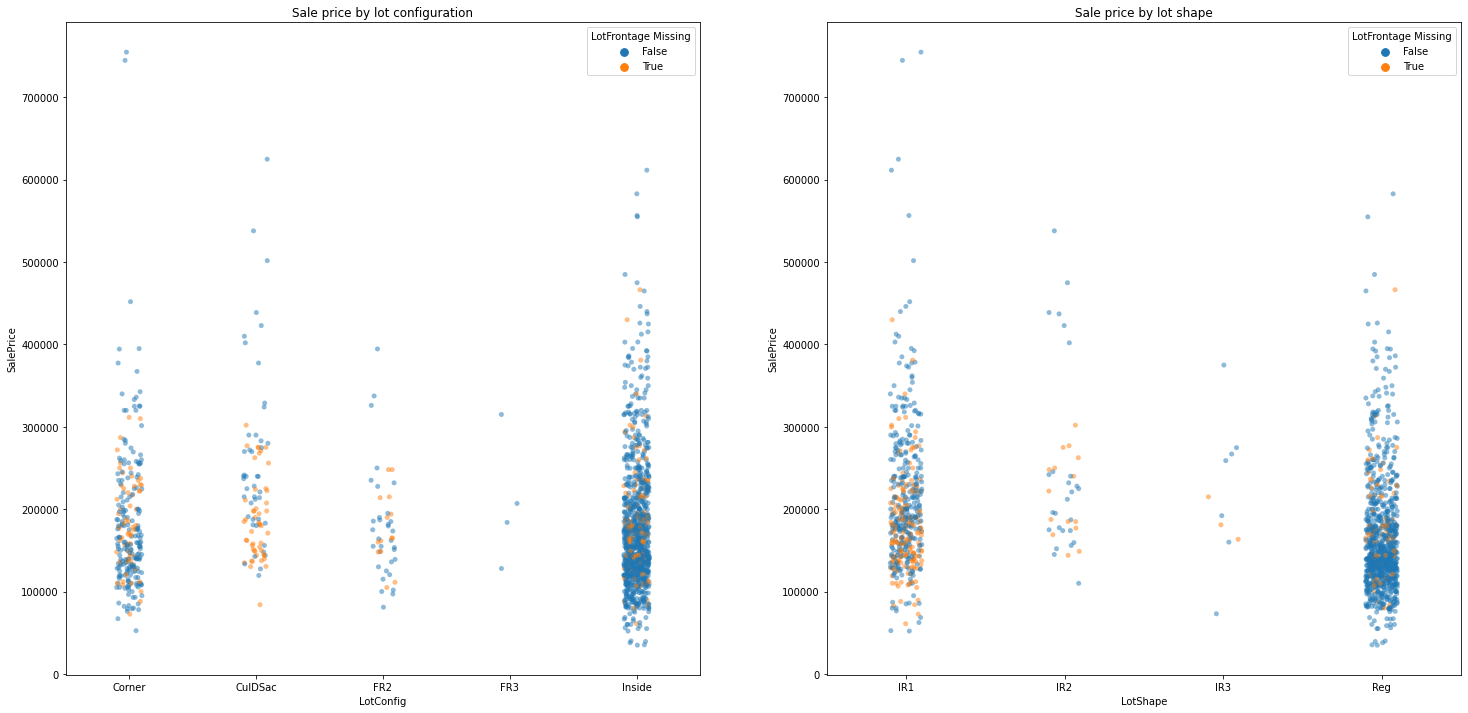

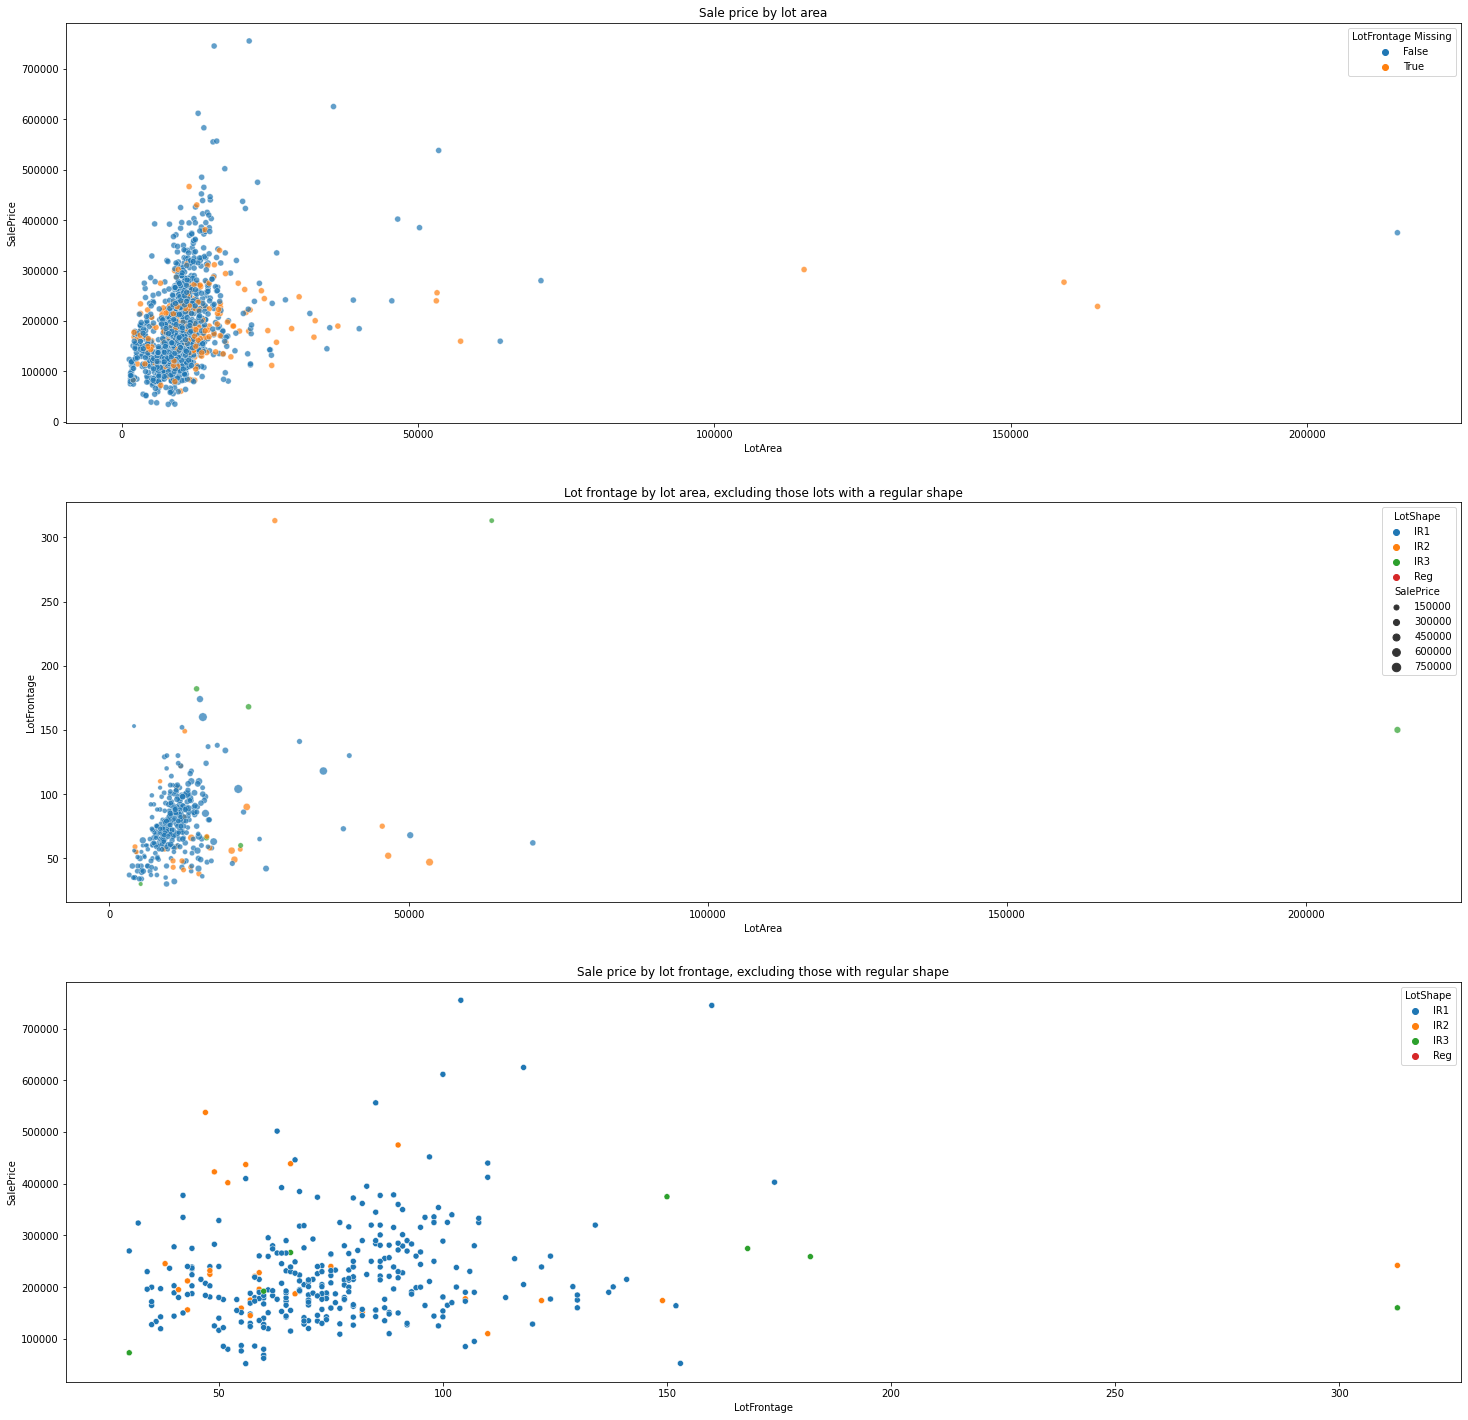

In [6]:
df['LotFrontage Missing'] = df['LotFrontage'].isna()
# sns.set(rc={'figure.figsize':(15,10)})
fig, ax = plt.subplots(1,2, figsize=(25,12))
sns.stripplot(data=df, x='LotConfig', y='SalePrice', hue='LotFrontage Missing', alpha=0.5, ax = ax[0])
ax[0].set_title('Sale price by lot configuration')
sns.stripplot(data=df, x='LotShape', y='SalePrice', hue='LotFrontage Missing', alpha=0.5, ax= ax[1])
ax[1].set_title('Sale price by lot shape')
plt.show()

fig,ax = plt.subplots(3,1,figsize=(25,25))
sns.scatterplot(data=df, x= 'LotArea', y='SalePrice', hue='LotFrontage Missing', alpha=0.7, ax= ax[0])
ax[0].set_title('Sale price by lot area')
sns.scatterplot(data=df[df['LotShape'] != 'Reg'], x= 'LotArea', y='LotFrontage', size='SalePrice', hue='LotShape', alpha=0.7, ax= ax[1])
ax[1].set_title('Lot frontage by lot area, excluding those lots with a regular shape')
sns.scatterplot(data=df[df['LotShape'] != 'Reg'], x= 'LotFrontage', y='SalePrice', hue = 'LotShape', ax= ax[2])
ax[2].set_title('Sale price by lot frontage, excluding those with regular shape')
plt.show() 

df.drop('LotFrontage Missing',axis=1,inplace=True)

In [7]:
df.drop('LotFrontage', axis=1,inplace=True)
df_test.drop('LotFrontage', axis=1,inplace=True)

## Basement features

There are three features with numerous missing values:

* BsmtCond
* BsmtQual
* BsmtExposure

Then there are several with just one in the test set:

* BsmtFinSF1
* TotalFinSF
* BsmtUnfSF
* KitchenQual
* BsmtFinSF2

Firstly, we can see that all of those missing both BsmtCond and BsmtQual do not have a basement. We will miss these and the correspoding BsmtExposure missing values with zeros. We see we can also fill the square footage variables with zeros too, as this house presumably had no basement.

In [8]:
bsmt_cols = ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF']

display(df[(df['BsmtQual'].isna()) & (df['BsmtCond'].isna())][bsmt_cols].head(50))
display(df_test[(df_test['BsmtQual'].isna()) & (df_test['BsmtCond'].isna())][bsmt_cols].head(50))

,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF
Id,,,,,,,,
18,NaN,NaN,NaN,NA,0,NA,0,0
40,NaN,NaN,NaN,NA,0,NA,0,0
91,NaN,NaN,NaN,NA,0,NA,0,0
103,NaN,NaN,NaN,NA,0,NA,0,0
157,NaN,NaN,NaN,NA,0,NA,0,0
183,NaN,NaN,NaN,NA,0,NA,0,0
260,NaN,NaN,NaN,NA,0,NA,0,0
343,NaN,NaN,NaN,NA,0,NA,0,0
363,NaN,NaN,NaN,NA,0,NA,0,0


,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF
Id,,,,,,,,
1586,NaN,NaN,NaN,NA,0.0,NA,0.0,0.0
1594,NaN,NaN,NaN,NA,0.0,NA,0.0,0.0
1730,NaN,NaN,NaN,NA,0.0,NA,0.0,0.0
1779,NaN,NaN,NaN,NA,0.0,NA,0.0,0.0
1815,NaN,NaN,NaN,NA,0.0,NA,0.0,0.0
1848,NaN,NaN,NaN,NA,0.0,NA,0.0,0.0
1849,NaN,NaN,NaN,NA,0.0,NA,0.0,0.0
1857,NaN,NaN,NaN,NA,0.0,NA,0.0,0.0
1858,NaN,NaN,NaN,NA,0.0,NA,0.0,0.0


In [9]:
# Filling the missing entries with zeros.

bsmt_fill_zeros = ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinSF1',
    'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']

for col in bsmt_fill_zeros:
    df.fillna({col:0},inplace=True)
    df_test.fillna({col:0},inplace=True)

As we see, this has dealt with all missing values.

In [10]:
display(df[bsmt_cols].isna().sum())
display(df_test[bsmt_cols].isna().sum())

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
dtype: int64

BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinSF1      0
BsmtFinType2    0
BsmtFinSF2      0
BsmtUnfSF       0
dtype: int64

## KitchenQual

There is just one record, which is in the test set, that is missing KitchenQual.

As we see from the extraction from the dataset below, the house in question does indeed have a kitchen, and the quality and condition ratings for all other features correspond to the average/typical rating.

We will therefore fill it with 'Typical/Average', which has been mapped to 3.

In [11]:
display(df_test[df_test['KitchenQual'].isna()][['KitchenAbvGr','Functional','ExterQual','ExterCond','OverallCond','OverallQual']].head())
df_test.fillna({'KitchenQual':3}, inplace = True)

,KitchenAbvGr,Functional,ExterQual,ExterCond,OverallCond,OverallQual
Id,,,,,,
1556,1,5.0,3,3,3,5


## Functional

The two records with missing Functional ratings are both houses with Abnormal sale conditions. They are both older single-family homes and have low ratings in exterior quality/condition, and one of overall condition/quality is the lowest possible (recall the overall scores are out of 10, so the 5 and 4 are average/below average).

In [12]:
cols_to_view = ['BldgType','HouseStyle','YearBuilt','KitchenQual','ExterQual','ExterCond','OverallCond','OverallQual','SaleCondition']
display(df_test[df_test['Functional'].isna()][cols_to_view].head())

,BldgType,HouseStyle,YearBuilt,KitchenQual,ExterQual,ExterCond,OverallCond,OverallQual,SaleCondition
Id,,,,,,,,,
2217,1Fam,1Story,1952,2.0,2,1,5,1,Abnorml
2474,1Fam,1.5Fin,1910,3.0,2,2,1,4,Abnorml


When we look at the older houses (built before 1970) in either the test set or training set where the overall condition or quality is no more than average and at least one of them is equal to 1, we see:

* only three other records with sale condition being Abnormal, and for these the functionality ratings are 2, 3, and 8.
* 6 out of 8 records have functionality 5 or below. The other 2 have rating of 8.

Comparing these numbers with the rest of the dataset, we see that to have functionality below 8 is rare, but also that the effect on sale price is not that significant until we get to functionalities of 2 or 3.

A sensible compromise seems to be to assign a rating of 4 to each of the records with missing values. This is the mean and mode of the set of similarly rated houses.

,Functional,BldgType,HouseStyle,YearBuilt,KitchenQual,ExterQual,ExterCond,OverallCond,OverallQual,SaleCondition
Id,,,,,,,,,,
376,4.0,1Fam,1Story,1922,2.0,2,2,1,1,Normal
2106,4.0,1Fam,2Story,1920,3.0,2,2,1,2,Normal
2100,3.0,1Fam,1Story,1949,3.0,3,3,1,3,Abnorml
1559,8.0,1Fam,2Story,1907,3.0,3,3,1,4,Abnorml
2474,NaN,1Fam,1.5Fin,1910,3.0,2,2,1,4,Abnorml
1832,2.0,Duplex,2Story,1922,3.0,3,3,1,5,Abnorml
2251,4.0,1Fam,2.5Unf,1900,3.0,3,3,1,5,Normal
534,8.0,1Fam,1Story,1946,2.0,2,2,3,1,Normal
2905,5.0,1Fam,1Story,1951,3.0,3,2,3,1,Normal


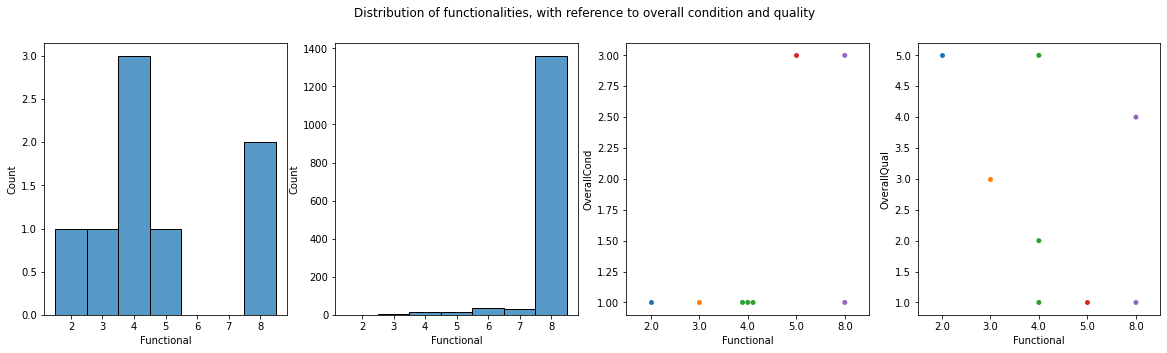

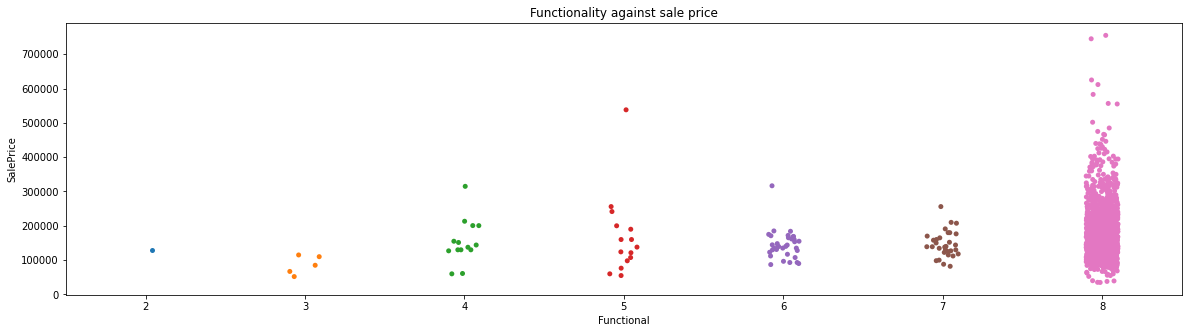

In [13]:
def make_mask(data):
    return ( # (data['SaleCondition'] == 'Abnorml') 
             (data['OverallCond'] < 6) 
            & (data['OverallQual'] < 6) 
            & (data['YearBuilt'] < 1970)
            & (  (data['OverallCond'] < 2) 
               | (data['OverallQual'] < 2) )
            )

mask1 = make_mask(df)
mask2 = make_mask(df_test)
temp_df1 = df[mask1][['Functional']+cols_to_view]
temp_df2 = df_test[mask2][['Functional']+cols_to_view]
temp_df = pd.concat([temp_df1, temp_df2])
display(temp_df.sort_values(['OverallCond','OverallQual']).head(50))

my_bins=[1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5]

fig,ax = plt.subplots(1,4,figsize=(20,5))
sns.swarmplot(data = temp_df, x='Functional', y='OverallCond', ax=ax[2])
sns.swarmplot(data = temp_df, x='Functional', y='OverallQual', ax=ax[3])
sns.histplot(data = temp_df, x='Functional', ax=ax[0], bins=my_bins)
sns.histplot(data = df, x='Functional', ax=ax[1], bins=my_bins)
fig.suptitle('Distribution of functionalities, with reference to overall condition and quality')
plt.show()
fig,ax = plt.subplots(1,1,figsize=(20,5))
sns.stripplot(data=df,x='Functional', y='SalePrice',ax=ax)
ax.set_title('Functionality against sale price')
plt.show()

df_test.fillna({'Functional':4.0}, inplace=True)

## Garage features

We first observe that those with missing GarageQual values in the training set are all ones with no garage. There are however 2 houses in the test set that have detched garages but missing values. For the missing values in the training set and the 76 missing values in the test set for houses with no garage, we can simply fill the missing values with zeros.

The 2 records in the test set though require further inspection. We see:

* Both garages are detatched from the house.
* They are both older houses (1910 and 1923).
* Their overall condition and quality are good (ranging from average to very good).
* Exterior condition is average.

In [14]:
garage_cols = ['GarageType', 'GarageFinish', 'GarageCars','GarageArea', 'GarageQual', 'GarageCond']
display(pd.DataFrame(
    {'Training set, no garage' : df[df['GarageType'] == 'NA'][garage_cols].isna().sum(),
     'Test set, no garage' : df_test[df_test['GarageType'] == 'NA'][garage_cols].isna().sum(),
     'Training set, with garage' : df[df['GarageType'] != 'NA'][garage_cols].isna().sum(),
     'Test set, with garage' : df_test[df_test['GarageType'] != 'NA'][garage_cols].isna().sum()}
))
display(df_test_orig[(df_test_orig['GarageFinish'].isna()) & (df_test['GarageType'] != 'NA')][garage_cols+cols_to_view+['Functional','GarageYrBlt','LotArea','1stFlrSF','BedroomAbvGr']].head(50))

,"Training set, no garage","Test set, no garage","Training set, with garage","Test set, with garage"
GarageType,0,0,0,0
GarageFinish,81,76,0,2
GarageCars,0,0,0,1
GarageArea,0,0,0,1
GarageQual,81,76,0,2
GarageCond,81,76,0,2


,GarageType,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,BldgType,HouseStyle,YearBuilt,KitchenQual,ExterQual,ExterCond,OverallCond,OverallQual,SaleCondition,Functional,GarageYrBlt,LotArea,1stFlrSF,BedroomAbvGr
Id,,,,,,,,,,,,,,,,,,,,
2127,Detchd,NaN,1.0,360.0,NaN,NaN,2fmCon,2.5Unf,1910,TA,TA,TA,8,6,Normal,Typ,NaN,8094,1242,5
2577,Detchd,NaN,NaN,NaN,NaN,NaN,1Fam,2Story,1923,Gd,TA,TA,6,5,Alloca,Typ,NaN,9060,942,3


The histograms below show the distribution of the other garage variables among those houses with similar properties (detatched garage, good or better overall condition, average or better overal quality, and older builds).
The key takeaways are:

* GarageFinish is almost always 1 (unfinished). We will fill the missing values with 1.
* GarageQual is mostly 3 (typical/average), sometimes 2 (fair). Given that 3 occurs more than 4 times as often as 2, we will fill these values with 3.
* GarageCond is almost always 3 (typical/average), so we will fill the missing values here with 3.
* For GarageCars (and hence GarageArea), this is split mostly between 1 car and 2 car garages. We can narrow down the filter by house size, lot size, house type and number of  bedrooms. This doesn't help much, but it does appear that 1 car garages are a bit more frequent in this sample. So we shall fill with 1 car and use the median for these types of garages (240) for area.

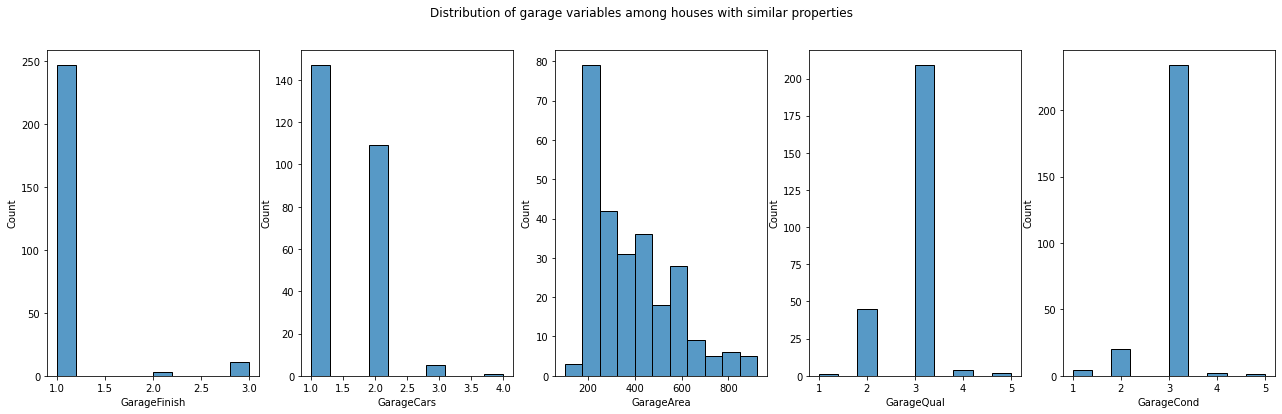

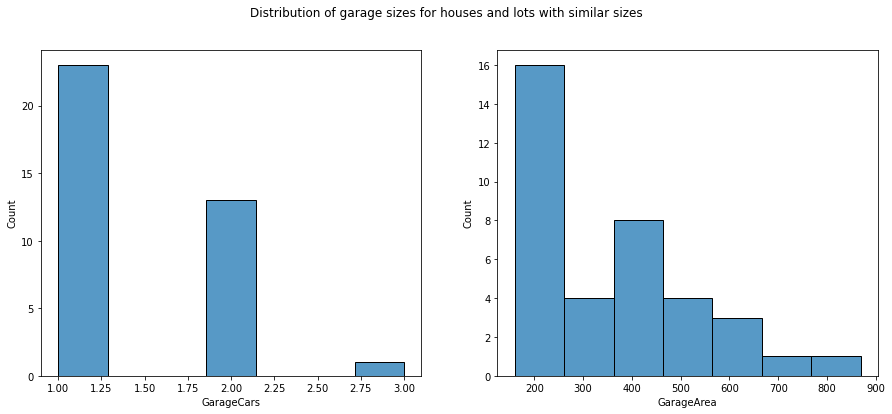

Mean garage area for similar 1 car garages: 269.30434782608694
Average garage area for similar 1 car garages: 240.0


In [15]:
def make_mask2(data):
    return ( (data['GarageType'] == 'Detchd')
            & (data['OverallCond'] > 5)
            & (data['OverallQual'] >= 5)
            & (data['YearBuilt'] < 1950)
           )

mask1=make_mask2(df)
mask2=make_mask2(df_test)
temp_df1 = df[mask1][garage_cols+cols_to_view].merge(df_orig[['LotArea','1stFlrSF','BedroomAbvGr']], left_index=True, right_index=True)
temp_df2 = df_test[mask2][garage_cols+cols_to_view].merge(df_test_orig[['LotArea','1stFlrSF','BedroomAbvGr']], left_index=True, right_index=True)
temp_df = pd.concat([temp_df1,temp_df2])

fig, ax = plt.subplots(1,5,figsize=(22,6))

garage_cols2 = ['GarageFinish', 'GarageCars','GarageArea', 'GarageQual', 'GarageCond']
for n, col in enumerate(garage_cols2):
    sns.histplot(data=temp_df, x=col,ax=ax[n])
fig.suptitle('Distribution of garage variables among houses with similar properties')
plt.show()

new_mask = ((temp_df['LotArea'] < 10000) 
            & (temp_df['LotArea'] > 800) 
            & (temp_df['1stFlrSF']>850) 
            & (temp_df['1stFlrSF']<1050) 
            & (temp_df['BldgType']=='1Fam') 
            & (temp_df['BedroomAbvGr'] == 3)
           )

fig,ax = plt.subplots(1,2,figsize=(15,6))
for n, col in enumerate(['GarageCars','GarageArea']):
    sns.histplot(data = temp_df[new_mask],
                 x = col, ax=ax[n])
fig.suptitle('Distribution of garage sizes for houses and lots with similar sizes')
plt.show()
print(f"Mean garage area for similar 1 car garages: {temp_df[new_mask & (temp_df['GarageCars']==1)]['GarageArea'].mean()}")
print(f"Average garage area for similar 1 car garages: {temp_df[new_mask & (temp_df['GarageCars']==1)]['GarageArea'].median()}")

In [16]:
garage_fills = {'GarageFinish':1, 'GarageQual': 3, 'GarageCond':3, 'GarageCars':1, 'GarageArea':240}
df.fillna(garage_fills,inplace=True)
df_test.fillna(garage_fills,inplace=True)

## TotalFinSF

The house with the missing TotalFinSF value does not have a basement, so the total finished square footage is equal to the feature GrLivArea, which we use to fill the missing value.

In [17]:
display(df_test_orig[df_test['TotalFinSF'].isna()][cols_to_view+['GrLivArea','TotalBsmtSF','BsmtFinType1']])
df_test.fillna({'TotalFinSF':896},inplace=True)

,BldgType,HouseStyle,YearBuilt,KitchenQual,ExterQual,ExterCond,OverallCond,OverallQual,SaleCondition,GrLivArea,TotalBsmtSF,BsmtFinType1
Id,,,,,,,,,,,,
2121,1Fam,1Story,1946,TA,TA,TA,7,4,Abnorml,896,NaN,NaN


# Correlations<a id='corr'></a>

## Numerical features

We first look at correlation between features. We are looking for two things here:

* Pairs of features that show correlation with one-another.
 * The highest correlation here is between `GarageCars` and `GarageArea` with a correlation coefficient of 0.88. We will drop `GarageCars`.
 * Other pair-wise correlations are highest for `ExerQual` and `OverallQual`; `KitchenQual` and `Exterior Qual`; `TotalFinSF` and `BsmtFinSF1`; `Total Bathrooms` and `TotalFinSF`.
* Features that correlate with our target variable `SalePrice`.
 * `OverallQual` (0.79) is the highest. Other high scores are listed below.
 
We should be cautious interpretting these scores (low values in particular), since many of the variables originated as (ordinal) categorical variables.

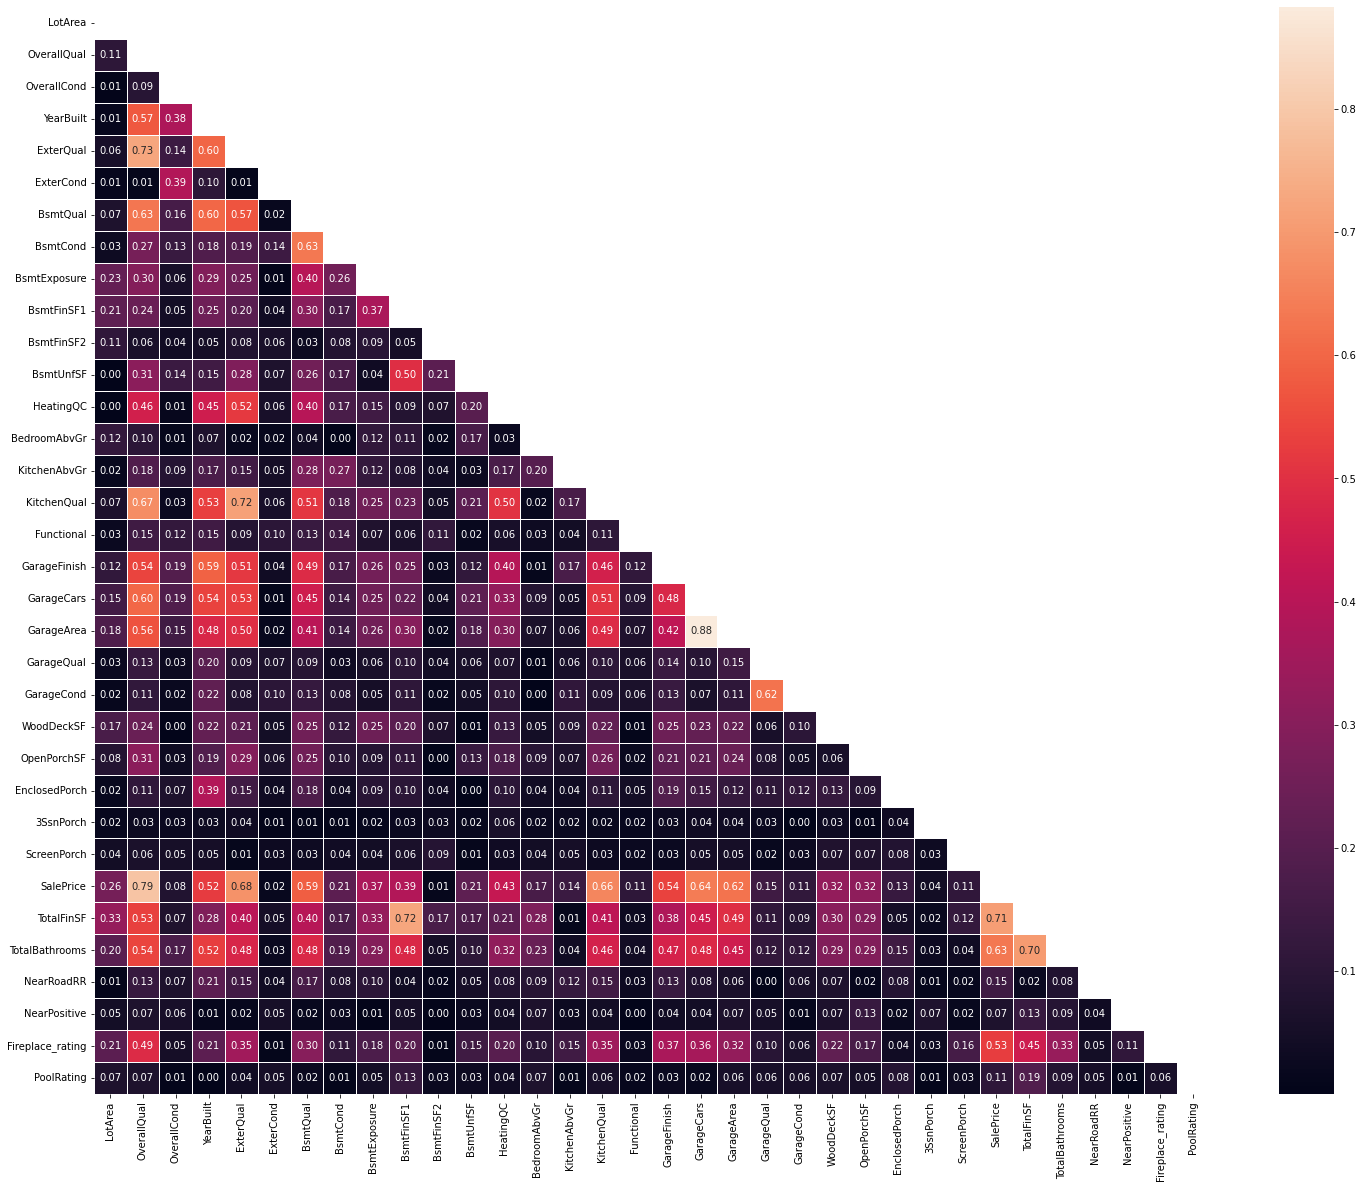

In [18]:
df_corr = np.abs(df.corr())
mask = np.triu(np.ones_like(df_corr, dtype=bool))

fig,ax=plt.subplots(figsize=(25,20))
sns.heatmap(data=df_corr, mask=mask, ax=ax, annot=True, fmt=".2f", linewidth=.5)
plt.show()

In [19]:
df.drop('GarageCars',axis=1,inplace=True)
df_test.drop('GarageCars',axis=1,inplace=True)

Here we see the (numerical) features that show good linear correlation with the sale price.

In [20]:
df_corr[df_corr['SalePrice']>0.60]['SalePrice'].sort_values(ascending=False)

SalePrice         1.000000
OverallQual       0.790982
TotalFinSF        0.708047
ExterQual         0.682639
KitchenQual       0.659600
GarageCars        0.640409
TotalBathrooms    0.631731
GarageArea        0.623431
Name: SalePrice, dtype: float64

## Categorical features

The distributions of `SalePrice` for each category is shown below in kdeplots below (after performing a log transformation on the price).
Following this we perform ANOVA on each categorical feature, concluding that for each feature the distribution of `SalePrice` depends on the class. However, the impact on `SalePrice` varies, with `Neighborhood` having the most substantial impact (as measured by the $\omega^2$ score), and `LotConfig` and `Alley` having the smallest impact. We shall drop the features with $\omega^2$ score less than 0.05.

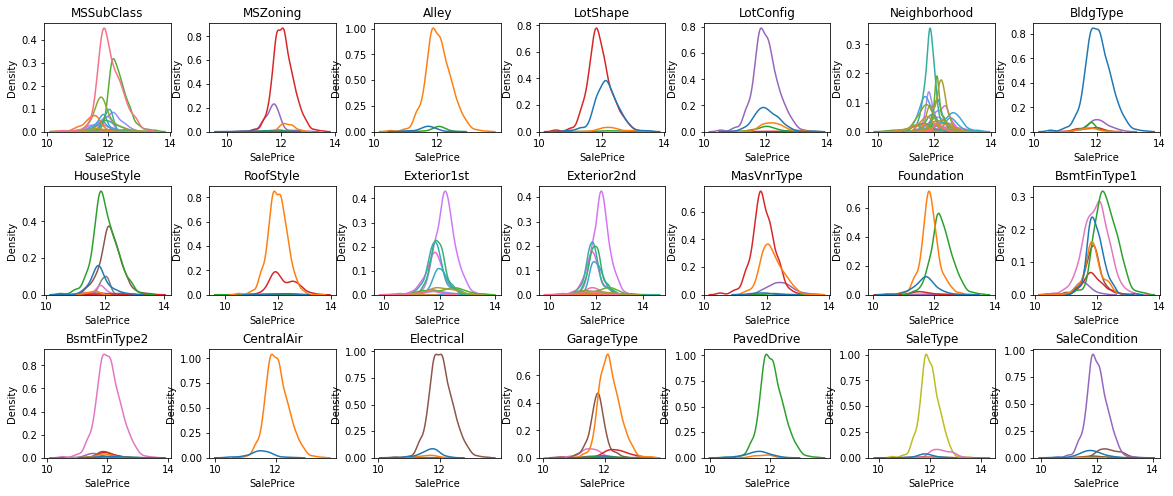

In [21]:
cat_mask = df.dtypes == 'category'
cat_cols = df.columns[cat_mask].tolist()
temp_df = df[['SalePrice']+list(cat_cols)].copy()
temp_df['SalePrice'] = np.log(df['SalePrice'])

fig, ax = plt.subplots(3,7, figsize = (20, 8))
for n, col in enumerate(cat_cols):
    sns.kdeplot(data=temp_df, hue=col, x='SalePrice', ax=ax[n // 7, n % 7], warn_singular=False, legend=False)
    ax[n//7,n%7].set_title(f"{col}")
    plt.subplots_adjust(wspace=0.3, hspace=0.5)
plt.show()

ANOVA, F-score for MSSubClass: 50.86611629720919, omega-squared score: 0.32348701996363594
ANOVA, F-score for MSZoning: 77.6078425310206, omega-squared score: 0.17347482348128657
ANOVA, F-score for Alley: 20.705973992835112, omega-squared score: 0.0262849365970551
ANOVA, F-score for LotShape: 46.72876194535902, omega-squared score: 0.08589247669645768
ANOVA, F-score for LotConfig: 8.692440102028343, omega-squared score: 0.0206401828272193
ANOVA, F-score for Neighborhood: 79.52042391519116, omega-squared score: 0.5634611184193424
ANOVA, F-score for BldgType: 15.211667391724593, omega-squared score: 0.03747687271722044
ANOVA, F-score for HouseStyle: 23.58576222546576, omega-squared score: 0.09770737456880882
ANOVA, F-score for RoofStyle: 13.097282599693699, omega-squared score: 0.03978096251395403
ANOVA, F-score for Exterior1st: 22.8922695830149, omega-squared score: 0.17350308597251635
ANOVA, F-score for Exterior2nd: 19.922005587328776, omega-squared score: 0.16276246547474268
ANOVA, F-

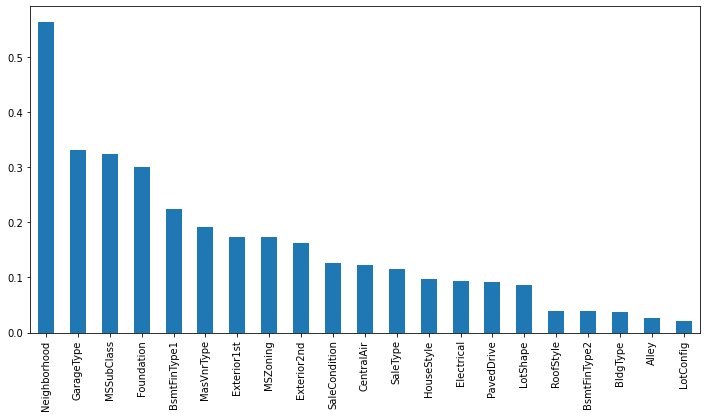

In [22]:
def anova(data,cat_col,num_col):
    '''
    Takes dataframe and two column and calculates F-statistics and omega squared value for the given columns.
    '''
    model = ols(f'{num_col} ~ C({cat_col})', data = data).fit()
    aov = sm.stats.anova_lm(model, typ=2)
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    omsq = ((aov[:-1]['sum_sq']-(aov[:-1]['df']*(aov['mean_sq'][-1])))/(sum(aov['sum_sq'])+aov['mean_sq'][-1]))
    return aov.loc[f'C({cat_col})','F'], omsq.iloc[0]


omsqs = {}
for col in cat_cols:   
    f,omsqs[col] = anova(temp_df,col,'SalePrice')
    print(f"ANOVA, F-score for {col}: {f}, omega-squared score: {omsqs[col]}")
    if omsqs[col] < 0.05:
        df.drop(col,axis=1,inplace=True)
        df_test.drop(col,axis=1,inplace=True)

    
    
omsqs_pd = pd.Series(omsqs).sort_values(ascending=False) 
fig, ax = plt.subplots(figsize=(12,6))
omsqs_pd.plot(kind='bar')
plt.show()

### Merging neighborhoods

We convert the `Neighborhood` feature into one that gives a rating of the neighborhood. The visualization below shows the different neighborhoods, with their mean, median and first and third quartiles for `SalePrice`. We can see that the neighborhoods naturally cluster into 6 groups. We shall use these clusters, with cutoffs coming from the median sale price to create a new column, called `nbhd_rating`, and drop the `Neighborhood` column. As we see, the $\omega^2$ score for the new column is very close to that of the old column.

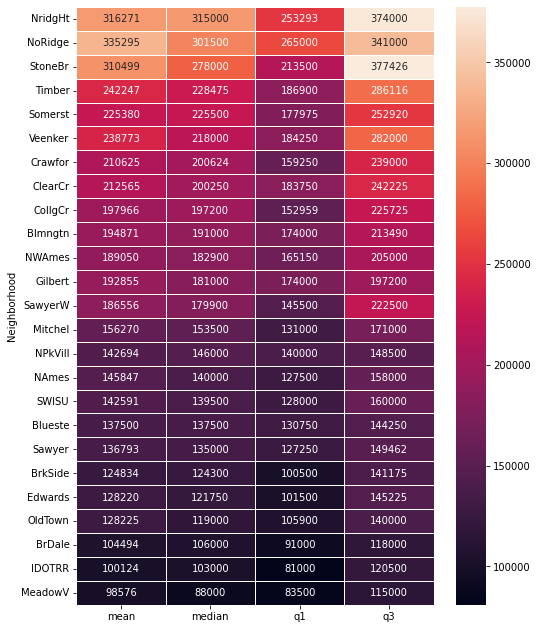

In [23]:
def q1(x):
    return x.quantile(0.25)
def q3(x):
    return x.quantile(0.75)

nbhd_df= df.groupby('Neighborhood')['SalePrice'].agg(['mean','median',q1,q3]).sort_values('median',ascending=False)
fig,ax = plt.subplots(figsize=(8,11))
sns.heatmap(data = nbhd_df,
            annot=True,
            fmt='.0f',
            linewidths=.5
           )
plt.show()

In [24]:
nbhd_ranks = {}
nbhd_map = {}
thresholds = [0,110000,130000,160000,210000,250000,10000000]
def nbhd_map_group(group,a,b):
    return list(nbhd_df[(nbhd_df['median'] > a) & (nbhd_df['median'] <= b)].index)
for i in range(len(thresholds)-1):
    nbhd_ranks[i] = nbhd_map_group(i,thresholds[i],thresholds[i+1])
    for nbhd in nbhd_ranks[i]:
        nbhd_map[nbhd] = i
        
df['nbhd_rating'] = df['Neighborhood'].apply(lambda x: nbhd_map[x])
df.drop('Neighborhood', axis=1, inplace=True)
df_test['nbhd_rating'] = df_test['Neighborhood'].apply(lambda x:nbhd_map[x])
df_test.drop('Neighborhood',axis=1,inplace=True)

In [25]:
temp_df['nbhd_rating'] = df['nbhd_rating']
print(f'Omega-squared with raw neighborhood data was {anova(temp_df, "Neighborhood","SalePrice")[1]:.4f}, with the neighborhood rating it is {anova(temp_df,"nbhd_rating","SalePrice")[1]:.4f}')

Omega-squared with raw neighborhood data was 0.5635, with the neighborhood rating it is 0.5626


# Dimension reduction

## Feature engineering with house features<a id='featureengineering'></a>

We create a host of new features using XGBoost, each new feature is based on a certain aspect of the house (garage, interior, exterior etc), but also incorporates 3 core features (`OverallQual`, `TotalFinSF`, `nbhd_rating`). 
This reduces the number of features to be used in the final model.

In [26]:
ext_cols = ['Exterior1st', 'Exterior2nd','MasVnrType', 'ExterQual', 'ExterCond']
bsmt_cols = ['BsmtQual','BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF']#, 'TotalBsmtSF']
garage_cols = ['GarageType', 'GarageFinish', 'GarageArea', 'GarageQual', 'GarageCond']
deck_cols = ['WoodDeckSF','OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch']
lot_cols = ['MSZoning', 'LotArea', 'LotShape','PavedDrive','NearRoadRR', 'NearPositive']
house_cols = ['MSSubClass', 'HouseStyle','Foundation','BedroomAbvGr','TotalBathrooms','Fireplace_rating','PoolRating']
utilities_cols = ['HeatingQC','CentralAir', 'Electrical']
interior_cols = ['KitchenAbvGr','KitchenQual']
overall_cols = ['OverallCond','Functional']
sale_cols = ['SaleType','SaleCondition']

core_cols = ['OverallQual', 'TotalFinSF', 'nbhd_rating']

sets = {'exterior':ext_cols,
      'bsmt':bsmt_cols,
      'garage':garage_cols,
      'deck':deck_cols,
      'lot':lot_cols,
      'house':house_cols,
      'utilities':utilities_cols,
      'interior':interior_cols,
      'overall':overall_cols,
      'sale':sale_cols}

# get CV scores, if they exist.
scores = {}
data_exists={}

def get_cv_past_scores(feature):    
    filename = {}
    filename['ihp'] = f"../input/iowa-house-prices/{feature}_cv_results.csv"
    filename['imm'] = f"../input/iowa-midmodel/{feature}_cv_results.csv"
    filename['working'] = f"{feature}_cv_results.csv"
    
    # check which is largest
    sizes = {}
    for idx, file in filename.items():
        if exists(file):
            sizes[idx] = getsize(file)
        else:
            sizes[idx] = 0
    idx_to_get = max(sizes, key = sizes.get)
    print(f"For {feature}, using {idx_to_get}")
    
    # either get data
    if exists(filename[idx_to_get]):            
        temp_cv_df = pd.read_csv(filename[idx_to_get], index_col=0)
        temp_cv_df = temp_cv_df.sort_values('mean_test_score',ascending=False).reset_index(drop=True)
        data_exists[feature]=True
        print(f"{feature}: past cv results loaded (shape: {temp_cv_df.shape}.")
        return temp_cv_df
    
    # or don't
    else:
        data_exists[feature]=False
        print(f"{feature}: past cv results *** not found ***")
        return 0
            
for feature in sets.keys():
    scores[feature] = get_cv_past_scores(feature)

For exterior, using ihp
exterior: past cv results loaded (shape: (2220, 16).
For bsmt, using ihp
bsmt: past cv results loaded (shape: (2220, 16).
For garage, using ihp
garage: past cv results loaded (shape: (2220, 16).
For deck, using ihp
deck: past cv results loaded (shape: (2220, 16).
For lot, using ihp
lot: past cv results loaded (shape: (2220, 16).
For house, using ihp
house: past cv results loaded (shape: (2220, 16).
For utilities, using ihp
utilities: past cv results loaded (shape: (2220, 16).
For interior, using ihp
interior: past cv results loaded (shape: (2220, 16).
For overall, using ihp
overall: past cv results loaded (shape: (2220, 16).
For sale, using ihp
sale: past cv results loaded (shape: (2139, 16).


In [27]:
def get_param_dics(feature,
                   add_variations = False, 
                   integer_args=['model__n_estimators', 'model__max_depth'], 
                   unit_interval_args = ['model__subsample', 'model__colsample_bytree']):
    
    def vary_params(param_dic):
        for arg in param_dic.keys():
            if len(param_dic[arg])==1:
                if arg in integer_args:
                    if param_dic[arg][0] == 1:
                        param_dic[arg] = [1,2,3]   
                    else:
                        param_dic[arg] = param_dic[arg] + [ int(param_dic[arg][0]*0.9), int(param_dic[arg][0]*1.1)+1 ]
                elif arg in unit_interval_args:
                    if param_dic[arg][0] == 1:
                        param_dic[arg] = [0.9,1]
                    else:
                        param_dic[arg] = param_dic[arg] + [ round(param_dic[arg][0]*0.9,3), min([round(param_dic[arg][0]*1.1,3),1]) ] 
                else:
                    param_dic[arg] = param_dic[arg] + [ round(param_dic[arg][0]*0.9,3), round(param_dic[arg][0]*1.1,3) ]
        return param_dic
    
   
    params = {}
    if data_exists[feature]:
        for arg in list(literal_eval(scores[feature].loc[0,'params']).keys()):
            params[arg]=[ scores[feature].sort_values('mean_test_score', ascending=False).reset_index().loc[0,'param_'+arg] ]
    else:
        params['model__n_estimators'] = [10,70,110]
        params['model__learning_rate'] = [0.1,1]
        params['model__max_depth'] = [1,7]
        params['model__subsample'] = [0.4,0.8]
        params['model__colsample_bytree'] = [0.4,0.8]
    if add_variations:
        return vary_params(params)
    else:
        return params
    
def make_pipe(scaler='standard', ohe=True):
    enc = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
    if scaler == 'standard':
        scaler = StandardScaler()
    elif scaler == 'minmax':
        scaler = MinMaxScaler()
    elif scaler == 'robust':
        scaler = RobustScaler()
    else:
        raise TypeError('Scaler input must be "standard", "minmax", or "robust".')
            
    model = xgb.XGBRegressor(random_state=1, n_jobs=-1)
    
    if ohe:
        pipe = Pipeline([('encoder',enc),
                       ('scaler',scaler),
                       ('model',model)])
    else:
        pipe = Pipeline([('scaler',scaler),
                       ('model',model)])
        
    return pipe

def run_cv(X,y,feature, pipe, param_grid):  
    '''
    Takes parameter grid and returns best model for the given feature.
    '''  
    t0 = time()
    grid_model = RandomizedSearchCV(pipe, param_grid, n_iter=60, cv=3, n_jobs=-1, verbose = 1, error_score='raise', scoring = 'neg_root_mean_squared_error')

    grid_model.fit(X, y)

    print(f"Fitting for {feature} took {time() - t0} seconds.")

    best_model = grid_model.best_estimator_

    y_pred = best_model.predict(X)
    score = np.sqrt(mean_squared_error(y,y_pred))

    new_scores = pd.DataFrame(grid_model.cv_results_)
    new_scores.sort_values('mean_test_score', ascending=False,inplace=True)

    print(f"{feature}: Best score {score}, best parameters: {grid_model.best_params_}\n")
    
    return best_model, new_scores

def save_cv_results(feature):
    filename = f"{feature}_cv_results.csv"
    scores[feature].to_csv(filename)
        
def bypass_cv(X,y,feature, pipe, params):
   
    for arg in params.keys():
        params[arg] = [params[arg][len(params[arg])//2]]
    shuf = ShuffleSplit(test_size=0.20, n_splits=1, random_state=0)
    
    t0 = time()
    grid_model = GridSearchCV(pipe, param_grid=params, cv=shuf, n_jobs=-1, verbose = 1, error_score='raise', scoring = 'neg_root_mean_squared_error')
    
    grid_model.fit(X, y)
    
    print(f"{feature}: model fitted in {time()-t0} seconds.")
    
    return grid_model

def training(X,y,feature, extend_cv = False, scaler='standard', ohe=True):
    param_dic = get_param_dics(feature, add_variations = extend_cv, integer_args=['model__n_estimators', 'model__max_depth'])
    print(param_dic)
    pipe = make_pipe(scaler,ohe)
    if extend_cv:
        best_model, new_scores = run_cv(X,y,feature, pipe, param_dic)
        if isinstance(scores[feature],int):
            scores[feature] = new_scores
        else:
            scores[feature] =  pd.concat([scores[feature], new_scores],ignore_index=True)
        save_cv_results(feature)
    else:
        best_model = bypass_cv(X,y,feature, pipe, param_dic)
    
    return best_model

def run_models(models):
    for feature in sets.keys():
        col_list = sets[feature]+core_cols
        X = df[col_list].values
        df[f"{feature}_rating"] = models[feature].predict(X)
        X_test = df_test[col_list].values
        df_test[f"{feature}_rating"] = models[feature].predict(X_test)

        # Drop old cols
        for col in sets[feature]:
            df.drop(col,axis=1,inplace=True)
            df_test.drop(col,axis=1,inplace=True)
            
    return df, df_test

In [28]:
best_models={}
for feature in sets.keys():
    col_list=sets[feature]+core_cols
    X = df[col_list].values
    y = df['SalePrice'].values
    best_models[feature] = training(X,y,feature, extend_cv=True)

{'model__subsample': [0.4, 0.36, 0.44], 'model__n_estimators': [181, 162, 200], 'model__max_depth': [7, 6, 8], 'model__learning_rate': [0.146, 0.131, 0.161], 'model__colsample_bytree': [0.36, 0.324, 0.396]}
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting for exterior took 262.69411635398865 seconds.
exterior: Best score 20908.82349033893, best parameters: {'model__subsample': 0.4, 'model__n_estimators': 181, 'model__max_depth': 7, 'model__learning_rate': 0.146, 'model__colsample_bytree': 0.36}

{'model__colsample_bytree': [0.44, 0.396, 0.484], 'model__learning_rate': [0.99, 0.891, 1.089], 'model__max_depth': [1, 2, 3], 'model__n_estimators': [89, 80, 98], 'model__subsample': [0.72, 0.648, 0.792]}
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting for bsmt took 170.33902215957642 seconds.
bsmt: Best score 32103.902507810213, best parameters: {'model__subsample': 0.72, 'model__n_estimators': 89, 'model__max_depth': 1, 'model__learning_rate': 0.891

In [29]:
df_eng, df_test_eng = run_models(best_models)

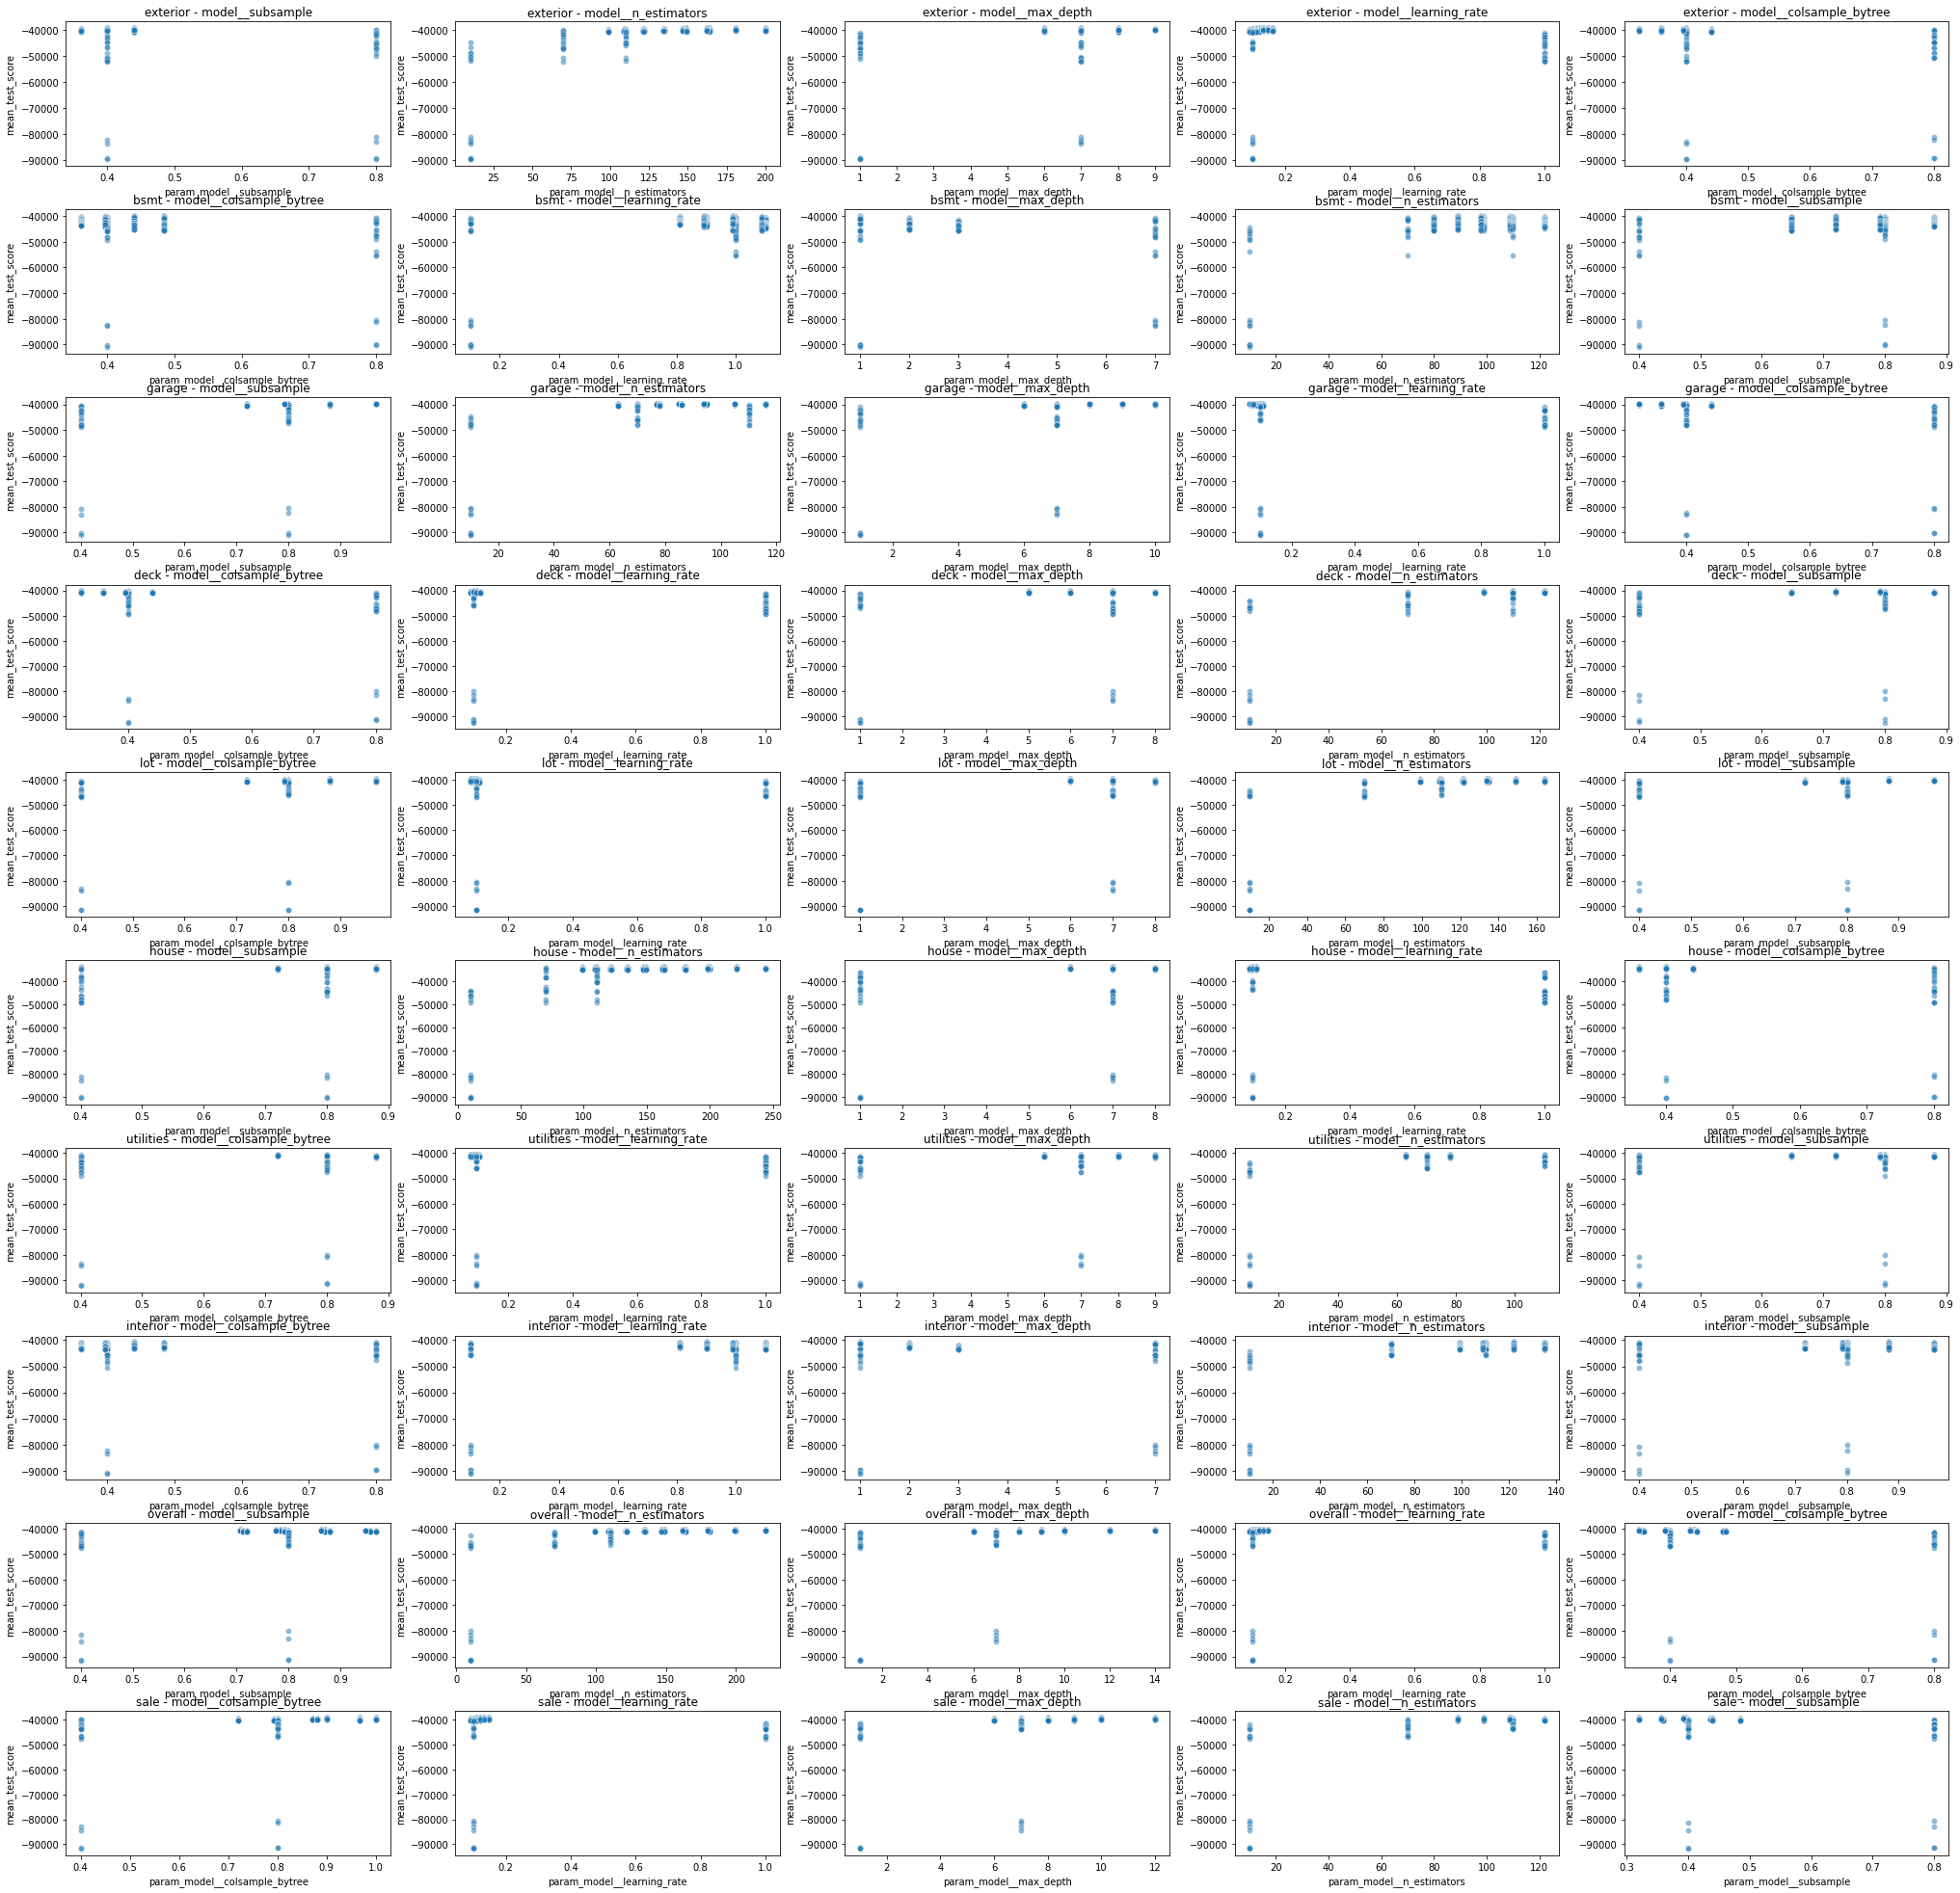

In [30]:
param_dics = {}
for feature in sets.keys():
    param_dics[feature] = get_param_dics(feature)

m=len(sets.keys())
n=max([len(param_dics[feature].keys()) for feature in sets.keys()])
fig, ax = plt.subplots(m,n,figsize=(35,35))
for i,feature in enumerate(sets.keys()):
    for j, arg in enumerate(param_dics[feature].keys()):
        sns.scatterplot(data = scores[feature], x= 'param_'+arg, y = 'mean_test_score', ax=ax[i,j], alpha=0.5)
        ax[i,j].set_title(f"{feature} - {arg}")
        plt.subplots_adjust(wspace=0.2,hspace=0.3)
plt.show()

In [31]:
for feature in sets.keys():
    param_cols = ['param_'+arg for arg in param_dics[feature].keys()]
    print(f"{feature}")
    display(scores[feature][param_cols+['mean_test_score']].head())

exterior


,param_model__subsample,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__colsample_bytree,mean_test_score
0,0.4,181,7,0.146,0.36,-39310.041766
1,0.4,181,7,0.146,0.36,-39310.041766
2,0.4,162,7,0.146,0.36,-39325.581501
3,0.4,162,7,0.146,0.36,-39325.581501
4,0.4,162,7,0.146,0.36,-39325.581501


bsmt


,param_model__colsample_bytree,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,mean_test_score
0,0.44,0.99,1,89,0.72,-39905.304464
1,0.44,0.99,1,89,0.72,-39905.304464
2,0.44,0.99,1,89,0.72,-39905.304464
3,0.44,0.99,1,89,0.72,-39905.304464
4,0.44,0.99,1,89,0.72,-39905.304464


garage


,param_model__subsample,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__colsample_bytree,mean_test_score
0,0.88,105,9,0.073,0.36,-39650.776469
1,0.88,105,9,0.073,0.36,-39650.776469
2,0.88,105,9,0.073,0.36,-39650.776469
3,0.88,105,9,0.073,0.36,-39650.776469
4,0.88,105,9,0.073,0.36,-39650.776469


deck


,param_model__colsample_bytree,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,mean_test_score
0,0.36,0.11,6,110,0.72,-40329.561405
1,0.36,0.11,6,110,0.72,-40329.561405
2,0.36,0.11,6,110,0.72,-40329.561405
3,0.36,0.11,6,110,0.72,-40329.561405
4,0.36,0.11,6,110,0.72,-40329.561405


lot


,param_model__colsample_bytree,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,mean_test_score
0,0.88,0.09,7,149,0.88,-39738.290317
1,0.88,0.09,7,149,0.88,-39738.290317
2,0.88,0.09,7,149,0.88,-39738.290317
3,0.88,0.09,7,149,0.88,-39738.290317
4,0.88,0.09,7,149,0.88,-39738.290317


house


,param_model__subsample,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__colsample_bytree,mean_test_score
0,0.8,221,7,0.1,0.4,-33703.887223
1,0.8,221,7,0.1,0.4,-33703.887223
2,0.8,221,7,0.1,0.4,-33703.887223
3,0.8,221,7,0.1,0.4,-33703.887223
4,0.8,198,7,0.1,0.4,-33704.123520


utilities


,param_model__colsample_bytree,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,mean_test_score
0,0.8,0.09,8,70,0.72,-40568.992398
1,0.8,0.09,8,70,0.72,-40568.992398
2,0.8,0.09,8,70,0.72,-40568.992398
3,0.8,0.09,8,70,0.72,-40568.992398
4,0.8,0.09,8,70,0.72,-40568.992398


interior


,param_model__colsample_bytree,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,mean_test_score
0,0.44,0.9,1,122,0.88,-40708.844856
1,0.44,0.9,1,122,0.88,-40708.844856
2,0.44,0.9,1,122,0.88,-40708.844856
3,0.44,0.9,1,122,0.88,-40708.844856
4,0.44,0.9,1,122,0.88,-40708.844856


overall


,param_model__subsample,param_model__n_estimators,param_model__max_depth,param_model__learning_rate,param_model__colsample_bytree,mean_test_score
0,0.862,180,12,0.133,0.392,-40453.701702
1,0.784,200,12,0.133,0.392,-40455.084893
2,0.784,200,12,0.133,0.392,-40455.084893
3,0.784,200,12,0.133,0.392,-40455.084893
4,0.784,200,12,0.133,0.392,-40455.084893


sale


,param_model__colsample_bytree,param_model__learning_rate,param_model__max_depth,param_model__n_estimators,param_model__subsample,mean_test_score
0,1.0,0.133,10,99,0.356,-39057.55658
1,1.0,0.133,10,99,0.356,-39057.55658
2,1.0,0.133,10,99,0.356,-39057.55658
3,1.0,0.133,10,99,0.356,-39057.55658
4,1.0,0.133,10,99,0.356,-39057.55658


# Visualizing the new features and transforming to Gaussian distributions<a id='new_feature_viz'></a>

We see the engineered features have distributions that are right skewed (which is expected from ratings based on house price).
To combat this we will apply a log transformation to these features.

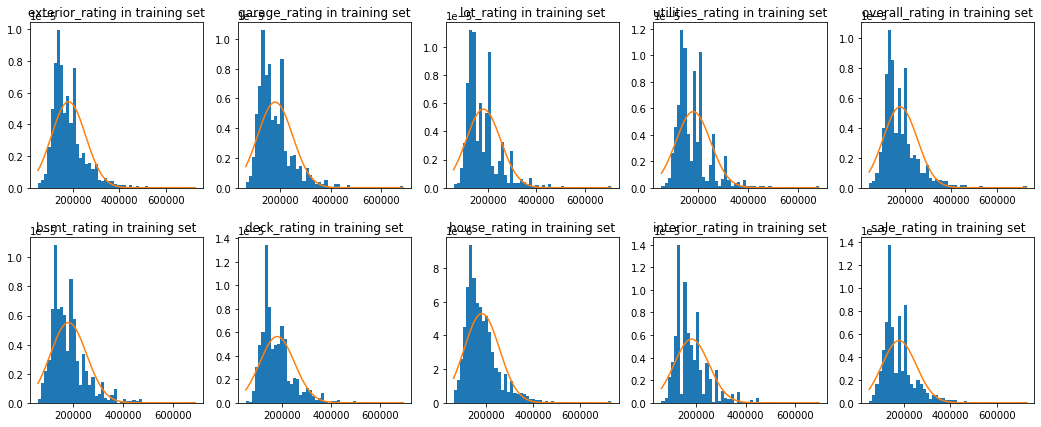

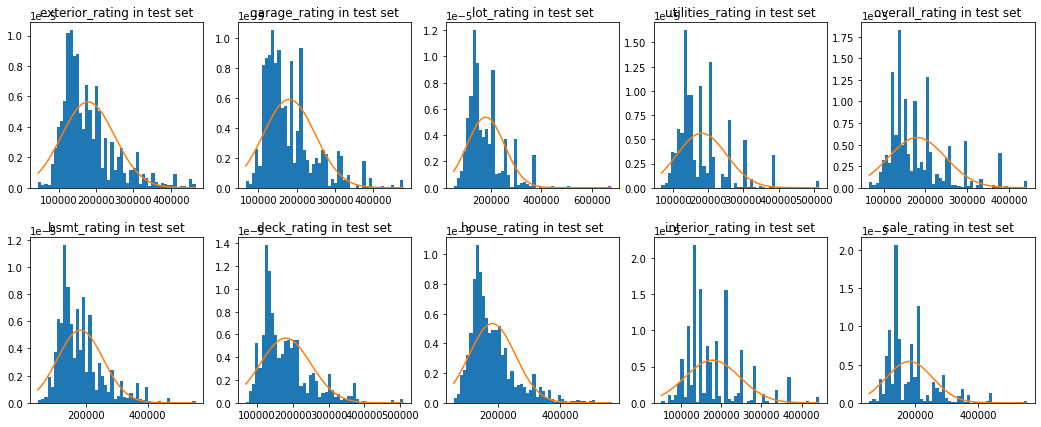

In [32]:
cols = [ f"{feature}_rating" for feature in sets.keys()]

def plot_features(data_list):
    for name,data in zip(['training set','test set'],data_list):
        fig, ax = plt.subplots(len(data_list),5,figsize=(18,7))
        for n,col in enumerate(cols):
            ax[n% 2, n//2].hist(x = data[col], density=True, bins = 50)
            ax[n% 2, n//2].set_title(f"{col} in {name}")
            mu = data[col].mean()
            sigma = data[col].std()
            a = data[col].min()
            b = data[col].max()
            x_axis = np.linspace(a,b,1000)
            ax[n% 2, n//2].plot(x_axis, norm.pdf(x_axis, mu, sigma))
            fig.subplots_adjust(wspace=0.2,hspace=0.3)
        plt.show()
        
plot_features([df_eng,df_test_eng])

In [33]:
df_eng2 = df_eng.copy()
df_test_eng2 = df_test_eng.copy()
for data in [df_eng2, df_test_eng2]:
    for col in cols:
        data[col] = np.log(data[col])

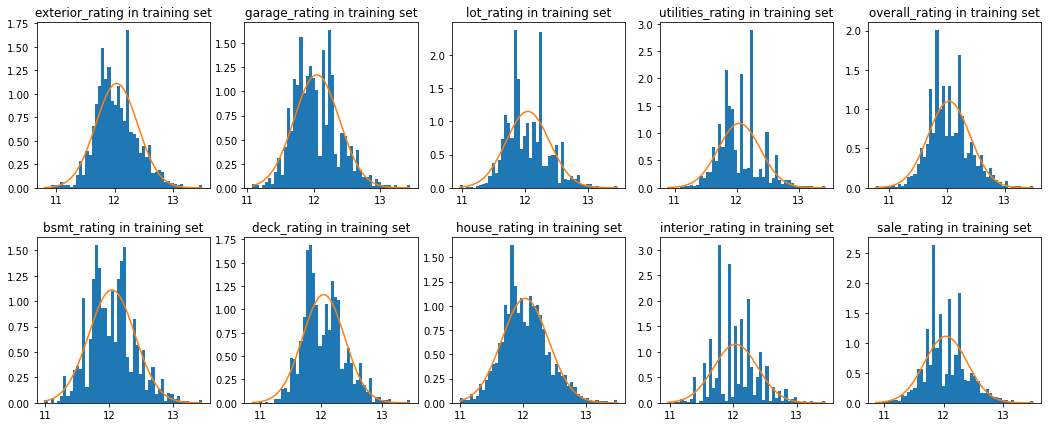

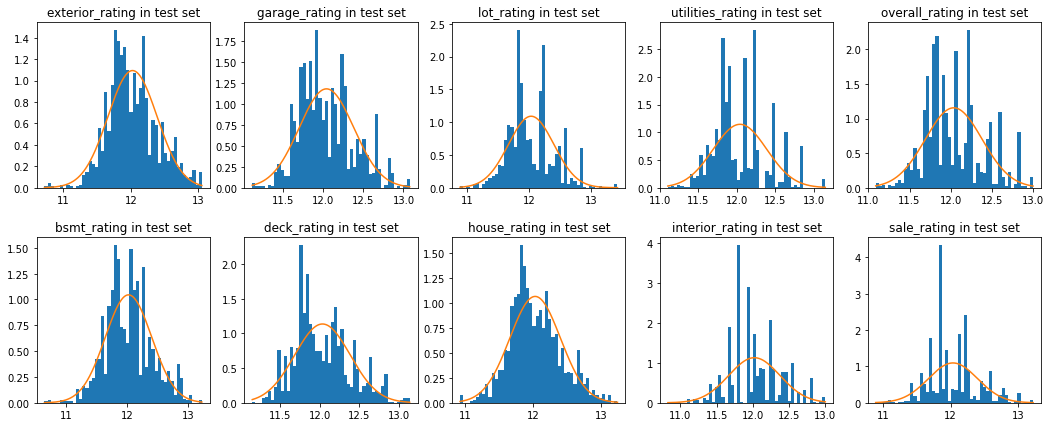

In [34]:
plot_features([df_eng2, df_test_eng2])

# Dimension reduction for visualization<a id='dimred'></a>

The aim is to visualize the data and determine whether there are natural clusters appearing within our datasets. As we vary the perplexity of the t-SNE model we see clusters forming, merging and splitting.

There appear to be multiple small clusters in each visualization, but they merge into perhaps 3 or 4 in the higher perplexity.
Since the plan is to train a model on each cluster, we don't want any cluster to be too small, so we will look to group together some of the smaller clusters.

In [35]:
def get_time_since_sold(data):
    data['Months_since_sold'] = (2010 - data['DateSold'].dt.year)*12 + (12 - data['DateSold'].dt.month) - 5
    return data.drop('DateSold', axis=1)

df_eng3 = get_time_since_sold(df_eng2)
df_test_eng3 = get_time_since_sold(df_test_eng2)

perplexity: 15


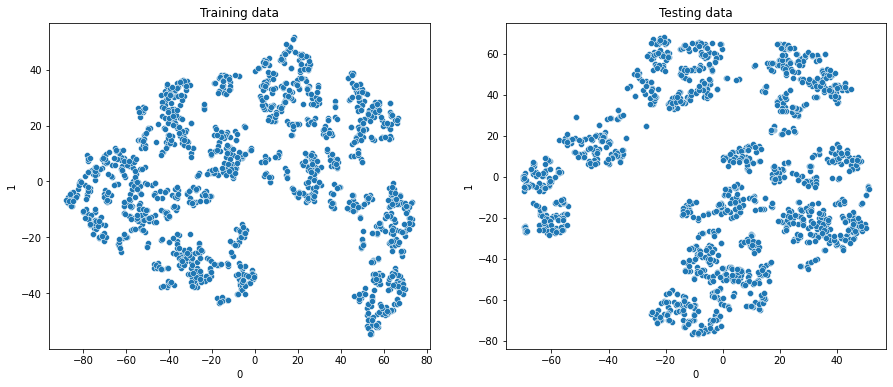

perplexity: 25


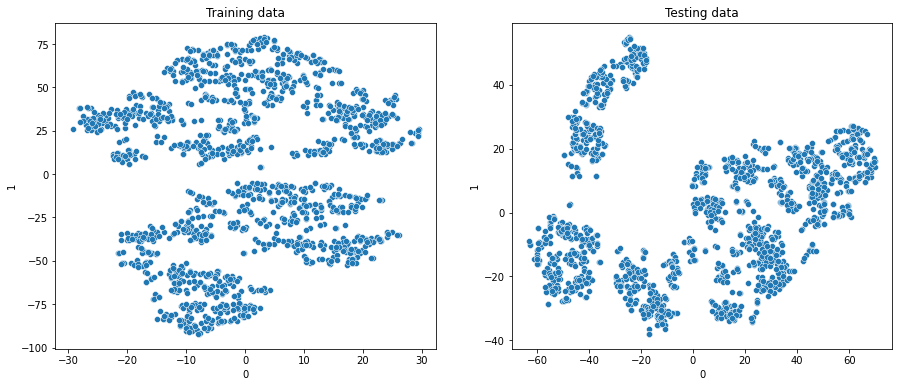

perplexity: 35


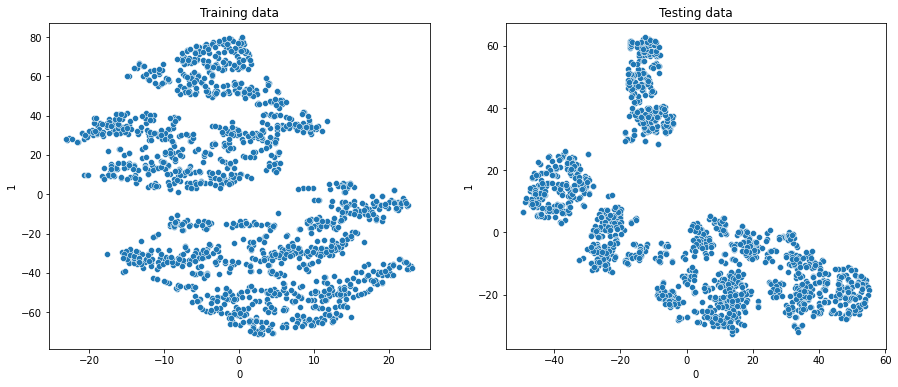

In [36]:
num_cols = df_test_eng3.columns[(df_test_eng3.dtypes == 'int64') | (df_test_eng3.dtypes == 'float64') | (df_test_eng3.dtypes == 'float32')].tolist()
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

for perp in [15,25,35]:
    
    print(f"perplexity: {perp}")

    sne_pipe = Pipeline([('scaler', StandardScaler()),
                         ('sne', TSNE(perplexity=perp, random_state=1))
                        ])

    df_sne = pd.DataFrame(sne_pipe.fit_transform(df_eng3[num_cols]))
    
    df_test_sne = pd.DataFrame(sne_pipe.fit_transform(df_test_eng3[num_cols]))
    fig, ax = plt.subplots(1,2,figsize=(15,6))
    sns.scatterplot(data=df_sne, x=0,y=1, ax=ax[0])
    ax[0].set_title('Training data')
    sns.scatterplot(data=df_test_sne,x=0,y=1,ax=ax[1])
    ax[1].set_title('Testing data')
    plt.show()

Next we reduce the dimension of the numnerical columns using PCA. Viewing the explained variances, we see that the first feature has a huge impact, and using that alone should give a strong model.

In [37]:
df_test_eng3.tail()

,OverallQual,YearBuilt,TotalFinSF,nbhd_rating,exterior_rating,bsmt_rating,garage_rating,deck_rating,lot_rating,house_rating,utilities_rating,interior_rating,overall_rating,sale_rating,Months_since_sold
Id,,,,,,,,,,,,,,,
2915,4,1970,1092.0,0,11.313651,11.296493,11.123236,11.320210,11.424880,11.242028,11.434694,11.406281,11.290309,11.100618,49
2916,4,1970,1344.0,0,11.404673,11.379025,11.514030,11.329576,11.489340,11.327137,11.427218,11.406281,11.434326,11.415447,51
2917,5,1960,2448.0,2,11.781712,11.780542,11.783616,11.822285,11.814940,11.904319,11.871740,11.803885,11.825108,11.495727,46
2918,5,1992,1307.0,2,11.688354,11.841739,11.721737,11.939273,11.814940,11.850415,11.825064,11.803885,11.810746,11.840032,48
2919,7,1993,2758.0,2,12.126940,12.047400,12.202872,12.174428,12.166797,12.242722,12.187401,12.071215,12.160697,12.206656,44


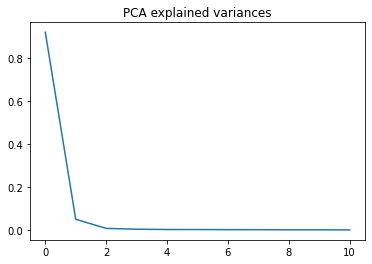

In [38]:
pca_cols = [f'{feature}_rating' for feature in sets.keys()]+['YearBuilt']

pca_pipe = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA())
                   ])

df_pca = pd.DataFrame(pca_pipe.fit_transform(df_eng3[pca_cols]))
df_test_pca = pd.DataFrame(pca_pipe.transform(df_test_eng3[pca_cols]))


plt.plot(range(pca_pipe['pca'].n_components_),  pca_pipe['pca'].explained_variance_ratio_)
plt.title('PCA explained variances')
plt.show()

# We need to regain the original indices

df_pca['Index']=df.index
df_pca.set_index('Index',inplace=True)
df_test_pca['Index']=df_test.index
df_test_pca.set_index('Index',inplace=True)

In the visualizations below, we see that the first PCA feature is essentially an amalgamation of all the numerical features, except date sold, with some weighing more than others. The scatter plot below shows strong linear correlation between this PCA feature and price.

The second PCA feature is mostly based on the total square footage of the house, while the third is mostly on the date sold (with a negative coefficient).

An earlier version of this notebook applied a simple linear regression model to just the first PCA feature.
This scored 0.19765 (v10) before we tuned the feature models above.

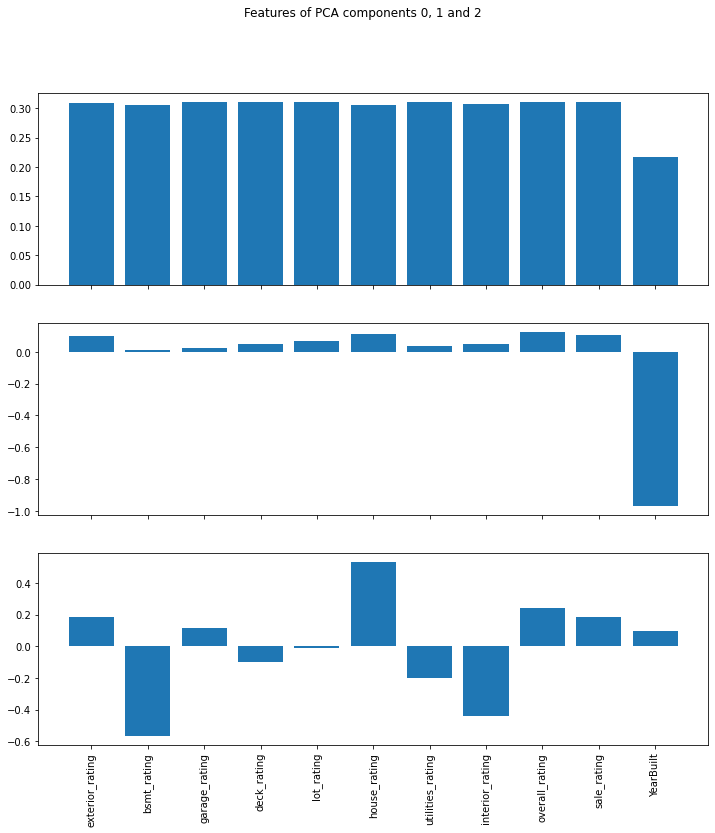

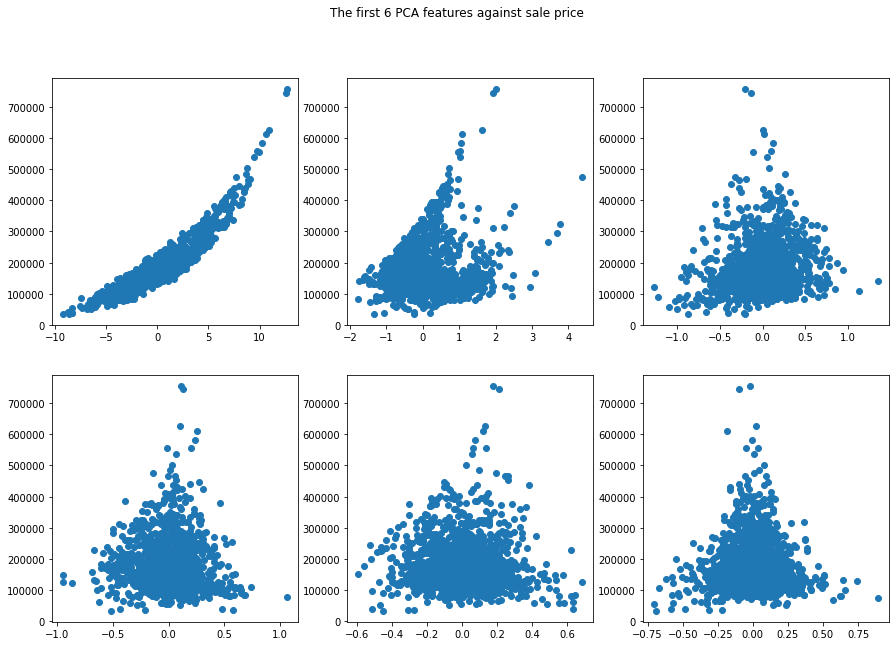

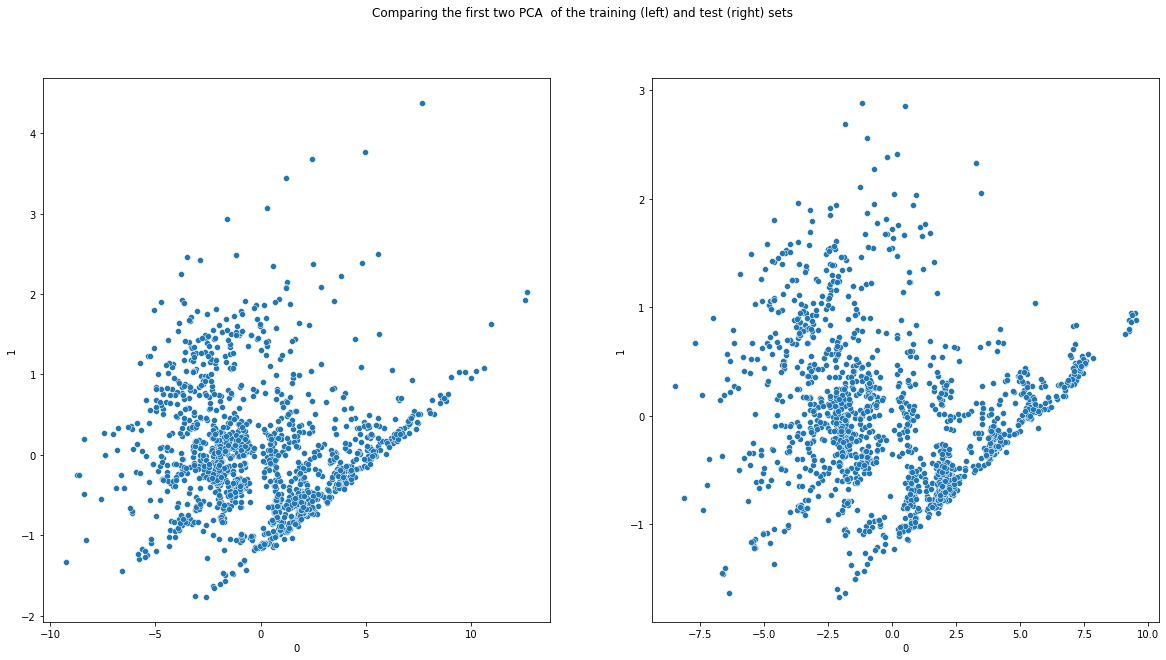

In [39]:
pca = pca_pipe['pca']
# fig, ax = plt.subplots(3,3,figsize=(20,15),sharey=True,sharex=True)
# for n in range(9):
#     ax[int(n/3),n%3].bar(x = df_eng1[num_cols].columns, height = pca.components_[n])
#     ax[int(n/3),n%3].set_xticklabels(labels = df_ohe.drop('SalePrice',axis=1).columns, rotation=90)
# fig.suptitle('The first 9 PCA features')
# plt.show()

fig, ax = plt.subplots(3,1,figsize=(12,12),sharex=True)
ax[0].bar(x = pca_cols, height = pca.components_[0])
ax[1].bar(x = pca_cols, height = pca.components_[1])
ax[2].bar(x = pca_cols, height = pca.components_[2])
ax[0].set_xticklabels(labels = pca_cols, rotation=90)
ax[1].set_xticklabels(labels = pca_cols, rotation=90)
ax[2].set_xticklabels(labels = pca_cols, rotation=90)
plt.suptitle('Features of PCA components 0, 1 and 2')
plt.show()

fig,ax = plt.subplots(2,3,figsize=(15,10))
for n in range(6):
    ax[int(n/3),n%3].scatter(x=df_pca[n],y=df_eng3['SalePrice'])
fig.suptitle('The first 6 PCA features against sale price')
plt.show()

fig,ax = plt.subplots(1,2,figsize=(20,10))
sns.scatterplot(x=df_pca[0], y =df_pca[1], ax = ax[0])
sns.scatterplot(x=df_test_pca[0], y =df_test_pca[1], ax = ax[1])
fig.suptitle('Comparing the first two PCA  of the training (left) and test (right) sets')
plt.show()

# Clustering<a id='clustering'></a>

We will cluster the data using a Bayesian Gaussian mixture. The data we use for this has `YearBuilt` and the engineered features created above replaced by the first two PCA features (one we refer to as `pca` and the other as `pca_year_built`, since the latter is a slight variation on `YearBuilt` and the former has substantially higher variance).

As we see in the visualization, one cluster collects houses with a small `pca_year_built` value, indicating that these are the more recently built houses.

In [40]:
df_eng4 = df_eng3.copy()
df_test_eng4 = df_test_eng3.copy()
df_eng4['pca'] = df_pca[0]
df_eng4['pca_year_built'] = df_pca[1]
df_test_eng4['pca'] = df_test_pca[0]
df_test_eng4['pca_year_built'] = df_test_pca[1]
df_eng4.drop(pca_cols,axis=1,inplace=True)
df_test_eng4.drop(pca_cols,axis=1,inplace=True)

In [41]:
df_eng4.head()

,OverallQual,SalePrice,TotalFinSF,nbhd_rating,Months_since_sold,pca,pca_year_built
Id,,,,,,,
1,7,208500,2416,3,29,1.972083,-0.635631
2,6,181500,2240,4,38,0.692500,-0.047908
3,7,223500,2272,3,22,2.111839,-0.540875
4,7,140000,1933,3,53,0.157171,1.863155
5,8,250000,2853,5,19,4.696382,0.042311


In [42]:
from sklearn.mixture import BayesianGaussianMixture

n_clusters = 3

cluster_model = BayesianGaussianMixture(n_components = n_clusters, covariance_type = 'full', random_state = 1)

df_test_eng4['Index']=df_test.index
df_test_eng4.set_index('Index',inplace=True)

cluster_model.fit(df_eng4.drop('SalePrice',axis=1))
df_eng4['class'] = cluster_model.predict(df_eng4.drop('SalePrice',axis=1))
# df_pca['class'] = df_eng4['class']
df_test_eng4['class'] = cluster_model.predict(df_test_eng4)
# df_test_pca['class'] = df_test_eng4['class']

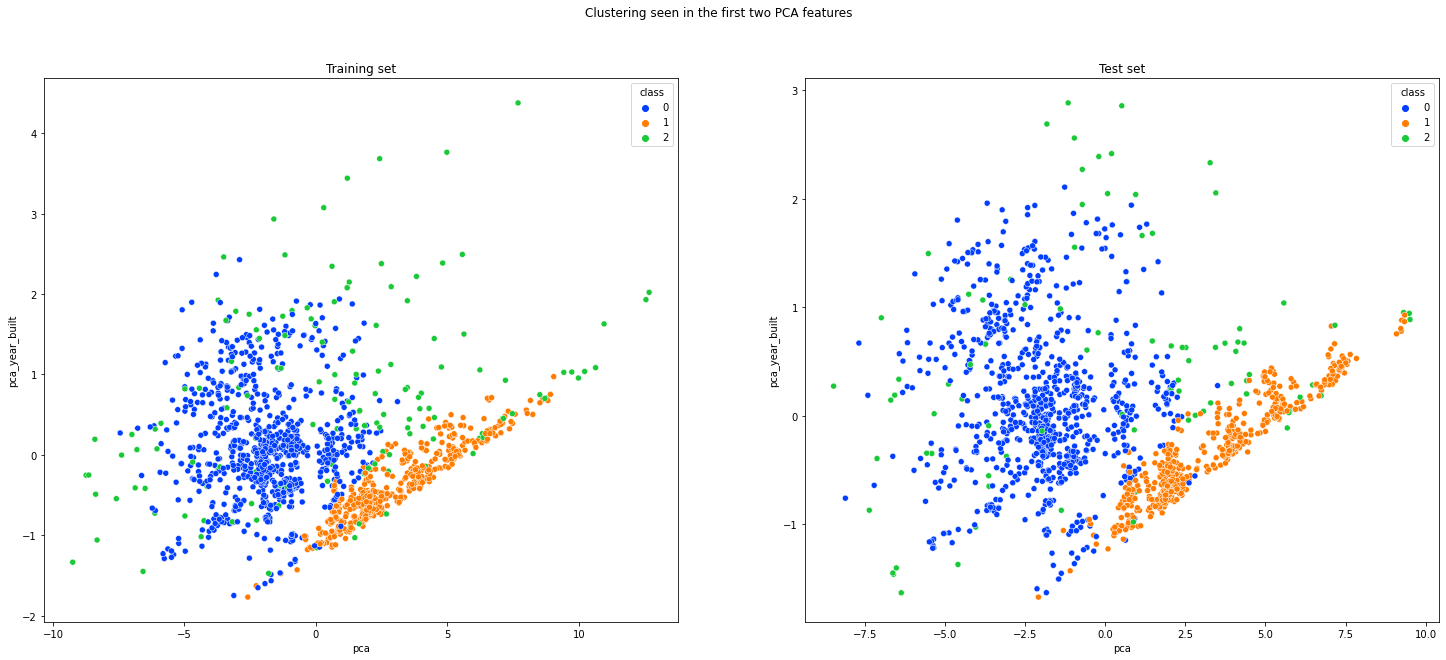

In [43]:
fig,ax = plt.subplots(1,2,figsize=(25,10))
sns.scatterplot(x='pca', y ='pca_year_built', hue = 'class', data= df_eng4, ax=ax[0], palette='bright')
sns.scatterplot(x='pca', y ='pca_year_built', hue = 'class', data= df_test_eng4, ax=ax[1], palette='bright')
ax[0].set_title('Training set')
ax[1].set_title('Test set')
fig.suptitle('Clustering seen in the first two PCA features')
plt.show()

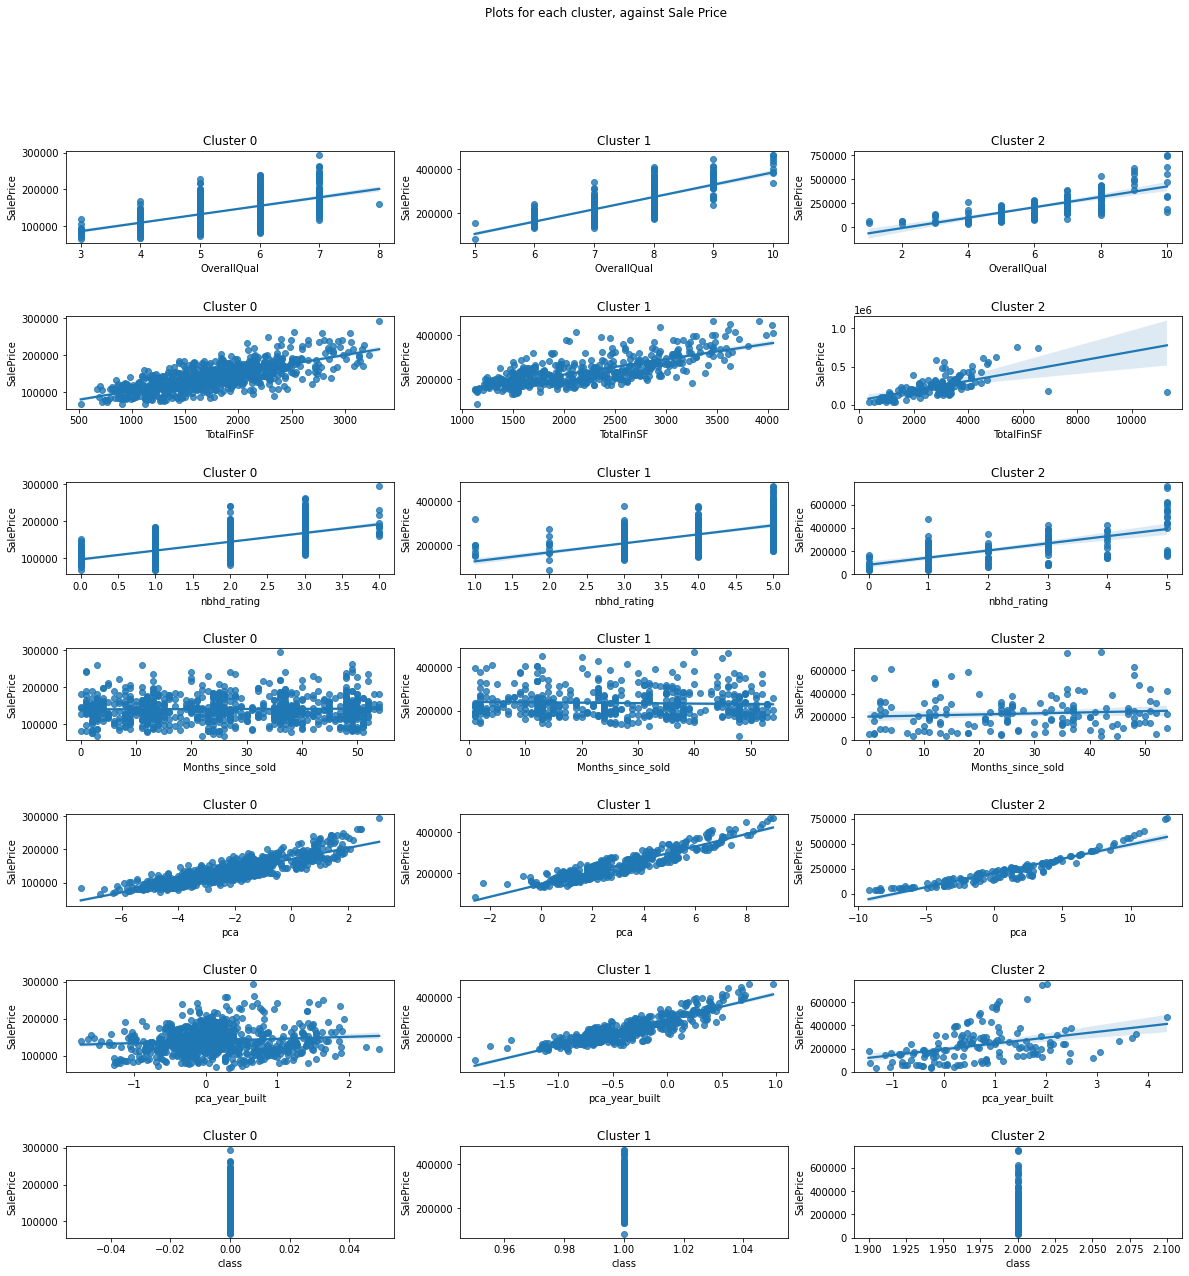

In [44]:
# fig,ax = plt.subplots(2,3,figsize=(20,15))
# for n in range(6):
#     sns.scatterplot(x=df_pca[n],y=df_eng4['SalePrice'], hue = df_eng4['class'], ax = ax[int(n/3),n%3], alpha = 0.5, palette = 'bright')
# fig.suptitle('The first 6 PCA features against sale price, colored by cluster')
# plt.show()

fig,ax = plt.subplots(len(df_test_eng4.columns),n_clusters, figsize = (20,20))
for n,col in enumerate(list(df_test_eng4.columns)):
    for i in range(n_clusters):
        sns.regplot(x = df_eng4[df_eng4['class'] == i][col], y = df_eng4[df_eng4['class'] == i]['SalePrice'], ax = ax[n,i])
        ax[n,i].set_title(f"Cluster {i}")
        ax[n,i].set_xlabel(f"{col}")
        plt.subplots_adjust(wspace=0.2,hspace=0.8)
fig.suptitle('Plots for each cluster, against Sale Price')        

plt.show()

# Model training<a id='modelling'></a>

We train some models to predict sale price of any house in Ames. 

We fit separate polynomial models on each cluster and amalgamate them.

In [45]:
def get_data(df, df_test):
    # Set up the data for fitting
    X_list = {}
    X_test_list = {}
    y_list = {}
    for x in range(n_clusters):
        if (df_test['class']==x).sum() > 0:
            X_list[x] = df[df['class']==x].drop(['class','SalePrice'],axis=1)
            X_test_list[x] = df_test[df_test['class']==x].drop('class',axis=1)
            y_list[x] = df[df['class']==x]['SalePrice']
    return X_list, X_test_list, y_list
        
def get_preds(X_list, X_test_list, y_list, pipes):
    # Predicting and getting scores
    for x in X_list.keys():
        X_list[x]['Prediction'] = pipes[x].predict(X_list[x])
        X_test_list[x]['Prediction'] = pipes[x].predict(X_test_list[x])
        X_list[x]['SalePrice'] = y_list[x]
        X_list[x]['class'] = x
        print(f"RMSE for cluster {x}: {np.sqrt(mean_squared_error(y_list[x], X_list[x]['Prediction']))}")
    df_final = pd.concat([X_list[x] for x in list(X_list.keys())])
    df_test_final =pd.concat([X_test_list[x] for x in list(X_list.keys())])
    df_test_final.sort_index(inplace=True)
    print(f"Overall RMSE: {np.sqrt(mean_squared_error(df_final['SalePrice'], df_final['Prediction']))}")
    
    return df_test_final

def run_final_models(df, df_test, extend_cv=True):
    X_list, X_test_list, y_list = get_data(df, df_test)
    fitted_pipes = {}
    for cluster in X_list.keys():
        scores[cluster] = get_cv_past_scores(cluster)
        fitted_pipes[cluster] = training(X_list[cluster],y_list[cluster],cluster,extend_cv=extend_cv,scaler='standard',ohe=False)
    return get_preds(X_list,X_test_list,y_list,fitted_pipes)

In [46]:
df_test_final = run_final_models(df_eng4, df_test_eng4, extend_cv=True)

For 0, using ihp
0: past cv results loaded (shape: (1734, 16).
{'model__colsample_bytree': [0.324, 0.292, 0.356], 'model__learning_rate': [0.121, 0.109, 0.133], 'model__max_depth': [5, 4, 6], 'model__n_estimators': [86, 77, 95], 'model__subsample': [0.8, 0.72, 0.88]}
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting for 0 took 22.564724683761597 seconds.
0: Best score 10383.142728893457, best parameters: {'model__subsample': 0.88, 'model__n_estimators': 77, 'model__max_depth': 4, 'model__learning_rate': 0.133, 'model__colsample_bytree': 0.356}

For 1, using ihp
1: past cv results loaded (shape: (1734, 16).
{'model__colsample_bytree': [0.792, 0.713, 0.871], 'model__learning_rate': [0.09, 0.081, 0.099], 'model__max_depth': [7, 6, 8], 'model__n_estimators': [122, 109, 135], 'model__subsample': [0.792, 0.713, 0.871]}
Fitting 3 folds for each of 60 candidates, totalling 180 fits
Fitting for 1 took 34.58817172050476 seconds.
1: Best score 4193.347027738755, best parameter

# Submission<a id='submission'></a>

In [47]:
# # best_model = grid.best_estimator_
# # chosen_model = linreg
# df_output = pd.DataFrame({'Id': df_test.index})
# df_output['SalePrice'] = final_grid.predict(df_test_ohe)
# df_output['SalePrice'] = df_test_final['Prediction']
df_test_final = df_test_final.reset_index()
df_output = df_test_final[['Index','Prediction']]
df_output = df_output.rename(columns = {'Index':'Id', 'Prediction':'SalePrice'})
df_output.to_csv('submission.csv',index=False)